In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import scipy.stats
# from nbody_objects import Grid, Particle, Box
# from nbody_functions import tree_insert_particle, create_tree, barnes_hut_calc_phi, direct_sum

import datetime

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16

# Hierarchical methods for $N$-body simulation: the Barnes-Hut Algorithm and the Fast-Multipole Method

\begin{align}
    \text{Zhan Keith Tay, Magdalene College. CRSid zkt23} \nonumber
\end{align}

\begin{align}
    23^{th} \text{April} \, 2023 \nonumber
\end{align}

## 1  Introduction
The N-body problem involves a system of $N$ bodies that all interact with each other, with the aim being predicting the effect of each individual body in the presence of all the others. This problem is of interest to a broad range of scientific fields, such as astronomy, fluid dynamics, and solid-state physics. For long-ranged and pairwise interactions, such as those governed by gravity and electrostatic forces, a naive approach to evaluate the forces/potential acting on any one of the particles requires a direct summation $N-1$ operations -- by considering the distances (and charges/masses) between the particle of interest and all the other $N-1$ particles. This has to be repeated for all $N$ particles, hence a direct summation requires $N(N-1)$ operations to evaluate the forces/potential on all of the particles in the system.

As no analytical solution exists in general (for $N>2$), numerical simulations are required to model and predict the behaviour of the system. This quickly becomes an issue when we have a large number of bodies in a system as the (time) complexity of the problem scales as $O(N^2)$ - increasing the number of particles by a factor of $100$ increases the number of operations (and hence time) required approximately by a factor $10, 000$.

Numerous algorithms have been proposed to reduce the complexity of the problem to below $N^2$. These include the Barnes-Hut method (also known as "tree code"), the fast multipole method and the particle-mesh (PM) method.
This work focuses on implementing the Barnes-Hut method \cite{1986Natur.324..446B} and the fast multipole method \cite{GREENGARD1987325}, which their ideal complexities scale as $N\log N$ and $N$ respectively. More details about the PM method and its review can be found on \cite{PMmethodHockneyEastwood} and \cite{Bagla2005}. 

All the code presented here are self-written, but the concepts of the algorithms were based on \cite{Barnes-Hut} for the BH method and \cite{beatson1997short} for the FMM.
The next section discusses the quantity of interest of the project. Section 3 covers the Barnes-Hut Method, followed by the FMM in Section 4. The following of both algorithms will be discussed: its general idea, the algorithm, and the implementation complexities and errors. Possible improvements are suggested in Section 6. The report then concludes in Section 7.

The experiments were all executed on an AMD Ryzen 7 PRO 3700U w/ Radeon Vega Mobile Gfx 2.30 GHz processor.

## 2 Theoretical Aspects - the Potential
The majority of the theoretical aspects of this work are based on \cite{beatson1997short} (especially on the fast multipole method). The system examined is a group of point particles in a 2-dimensional space, where a (source) point of strength $q$ located at $\mathbf{x_0} = (x_0, y_0)$ gives rise to a potential $\phi$ at any (target) location $\mathbf{x} = (x, y) \neq \mathbf{x_0}$ of the following form

\begin{equation}
    \phi(x,y) = -q\log(||\mathbf{x}-\mathbf{x_0}||).
\end{equation}
This work will use the Barnes-Hut (BH) method and the fast multipole method (FMM) to find the potential at the locations of each of the point particles, caused by all other point particles in the system. 

The following explanation would only be relevant to the FMM, as the BH method only relies on the above equation \ref{eqn: log potential}. The implementation of FMM in this project uses complex analysis (and the given form of potential) to simplify notation. The above potential is such that away from the source points, the potential satisfies the Laplace equation

\begin{equation}
    \nabla^{2}\phi(x,y) = \frac{\partial^{2} \phi}{\partial x^{2}} + \frac{\partial^{2} \phi}{\partial y^{2}} = 0
\end{equation}
This is so that the potential is harmonic and hence can be expressed by an analytic function $u$ such that $\phi=Re(u)$. Using a complex number $z$ to represent spatial location $(x, y)$, 
\begin{equation}
    \phi(x,y) = Re\{u(z)\} = Re\{-q\log(z-z_0)\}.
\end{equation}
The FMM code will use complex analysis to evaluate $u(z)$, whose real part can then be taken as the real potential $\phi$.

## 3 The Barnes-Hut Method
### 3.1 General Idea
From the perspective of a (target) point, a distant galaxy, composed of a high number of constituent masses (acting as sources), can be approximated as a single "effective point mass" located at the centre of mass of the galaxy, having its mass as the sum of the constituent masses. The Barnes-Hut method works by first hierarchically organising a system of masses into groups of masses and then treating a sufficiently "far" group (wrt. to a target point) as one effective point mass, spatially located at the center of mass (c.o.m.) of that far group. This grouping method introduces an error as the effective point mass is only an approximate representation of the actual distribution of masses.

### 3.2 Algorithm
### 3.2.1 Tree construction
The following idea behind the code is based on \cite{Barnes-Hut} and \cite{1986Natur.324..446B}. Firstly, the entire space (a.k.a. "grid") containing the particles is divided into four quadrant boxes, and then each box is repeatedly divided into four further quadrant boxes until there is only one (or zero) particle left in each box. The particles are grouped in boxes hierarchically as shown in Figure \ref{fig: BH hierarchy} and \ref{fig: BH split box}. The boxes at the end of the tree without children only contain 0-1 particle and will also be referred to as "leaf boxes". These leaf boxes can exist at different levels (e.g. boxes 021, 023, 024 at level 2; boxes 0220, 0221, 0222, 0223 at level 3). Each of the boxes contains the following information: the c.o.m. and total mass of the particles in the box, its parent box, its children boxes (if they exist), and whether they contain any particle. For example, box 02 contains information about the com and total mass of 3 particles (see Figure \ref{fig: BH hierarchy}). Its parent is box 0 and children are boxes 012, 022, 023 and 024 (Figures \ref{fig: BH hierarchy} and \ref{fig: BH hierarchy}). Note that box 02 does not need to store the information about all three particles "within" it, it just stores an (approximate) representation of them i.e. the total mass and the c.o.m. of the three particles as one.

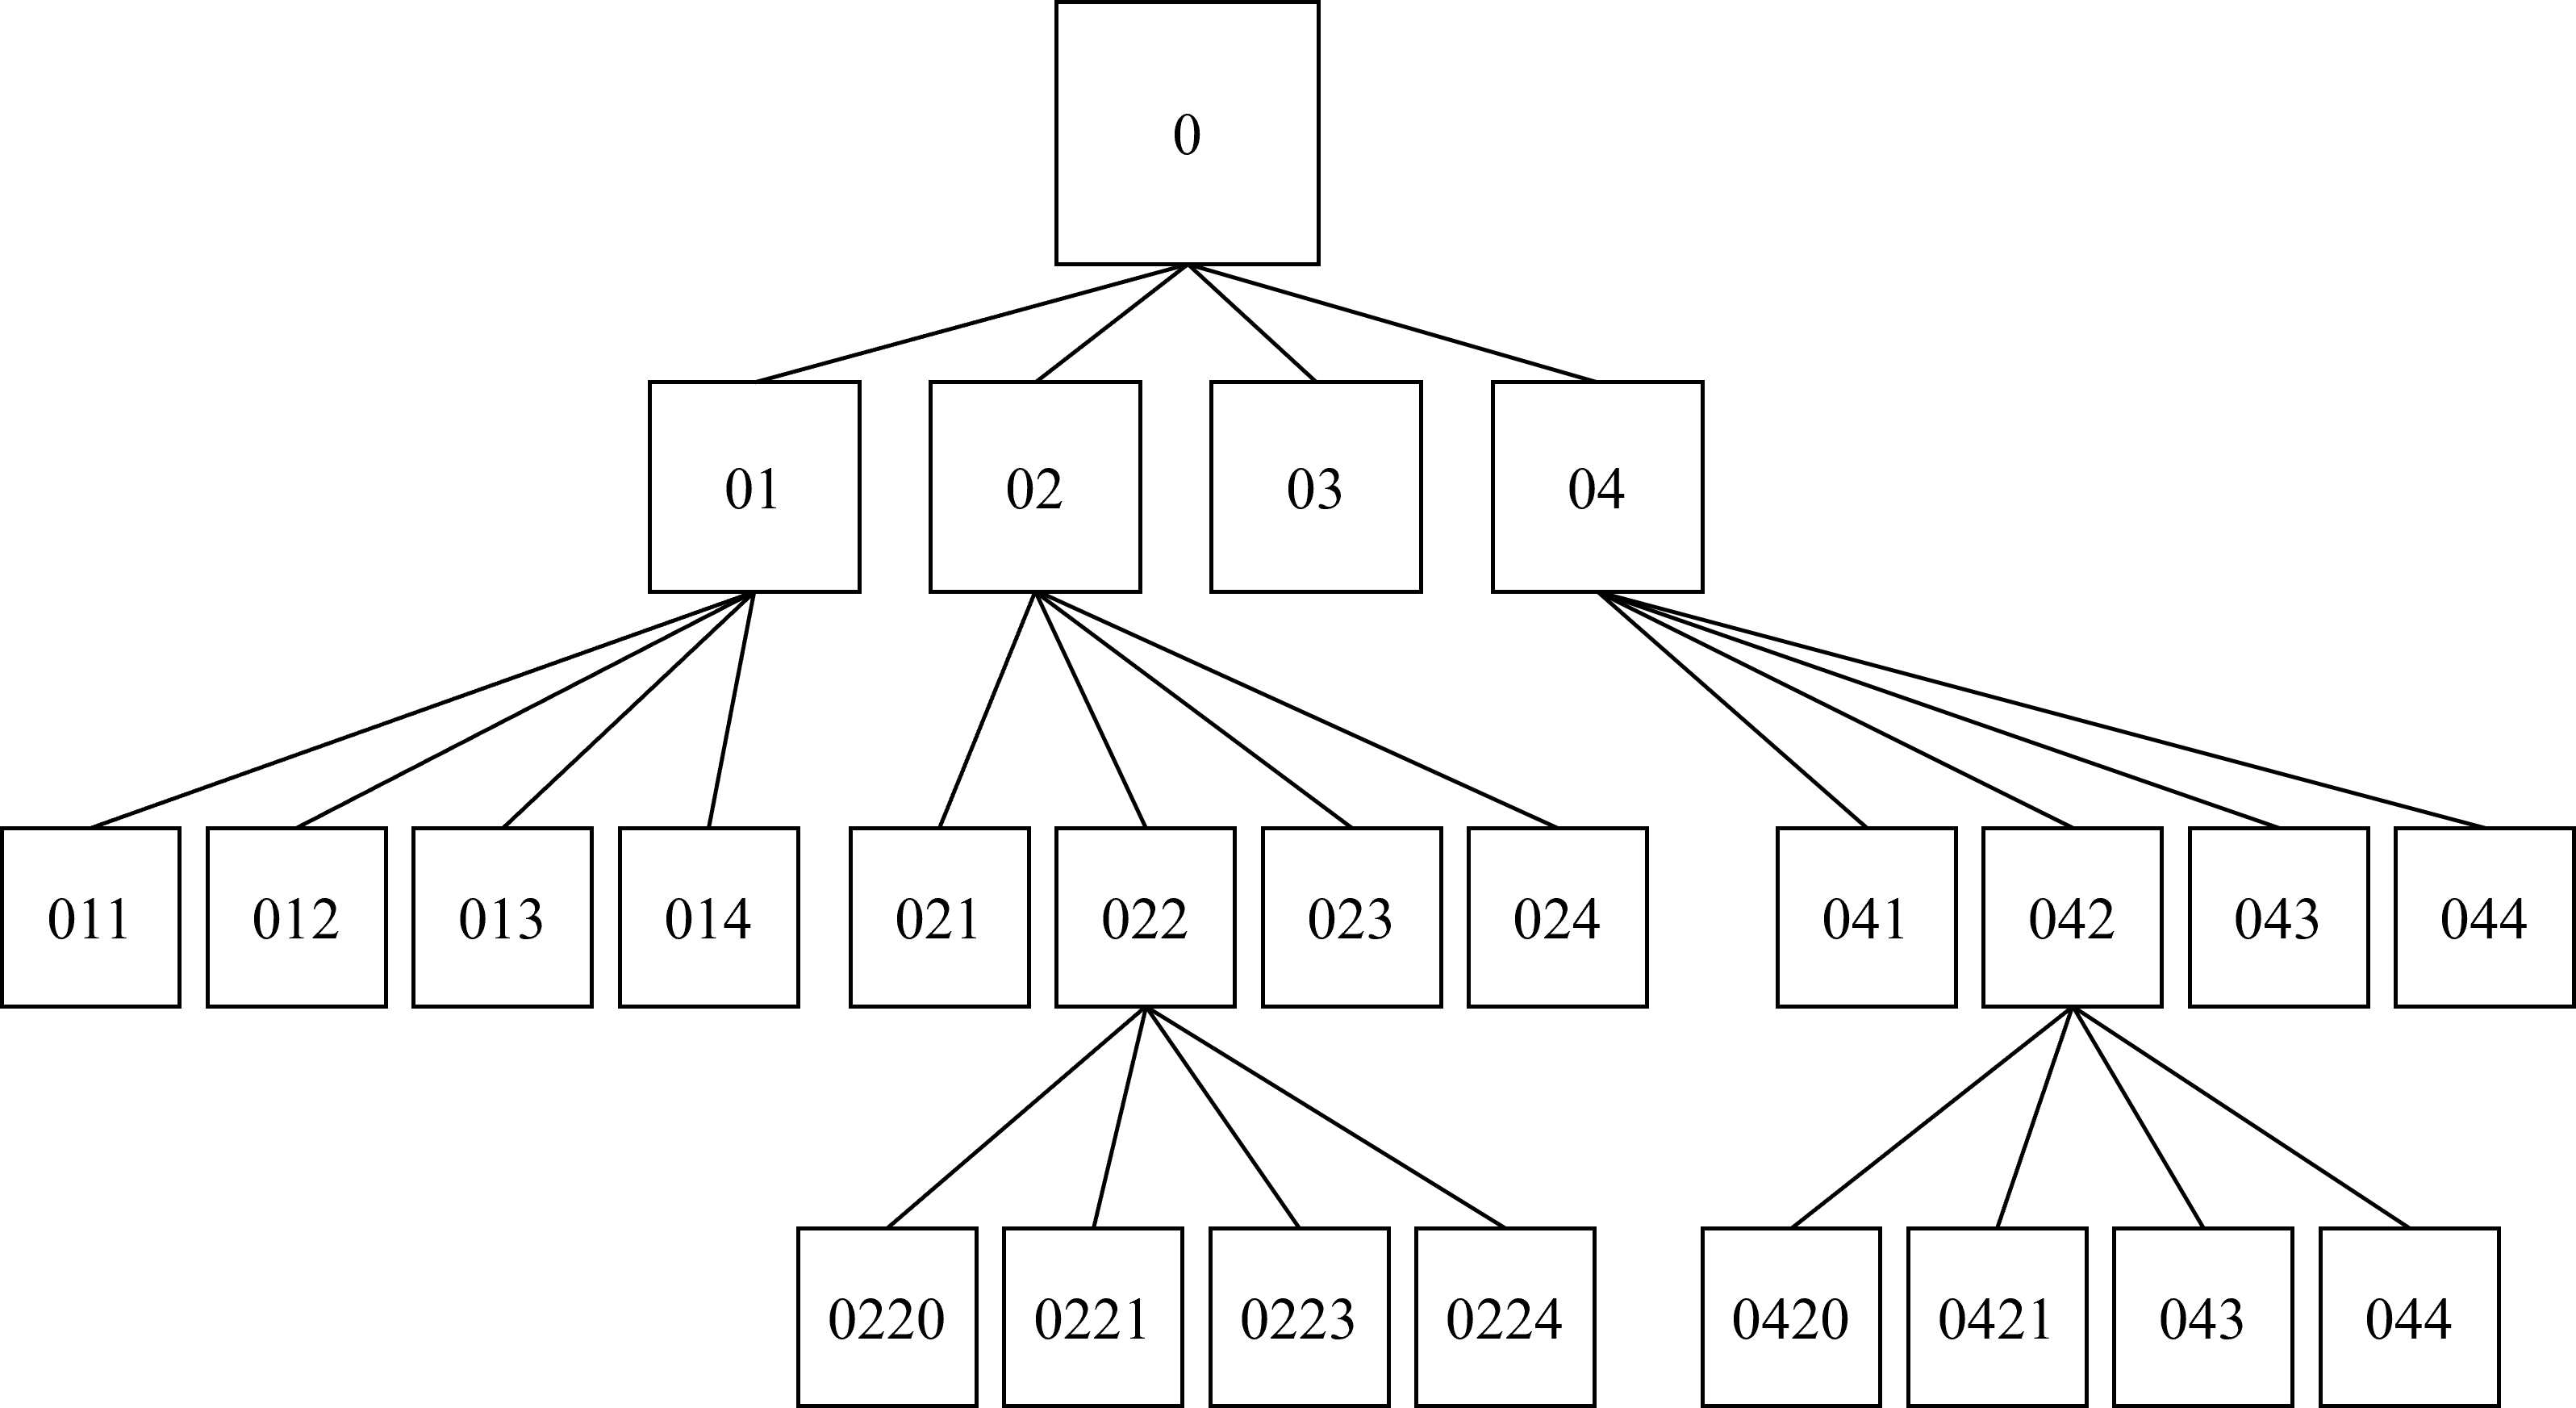
Figure 1: Barnes-Hut hierarchical-tree. Each box contains the centre of mass and total mass of the particles it contains.

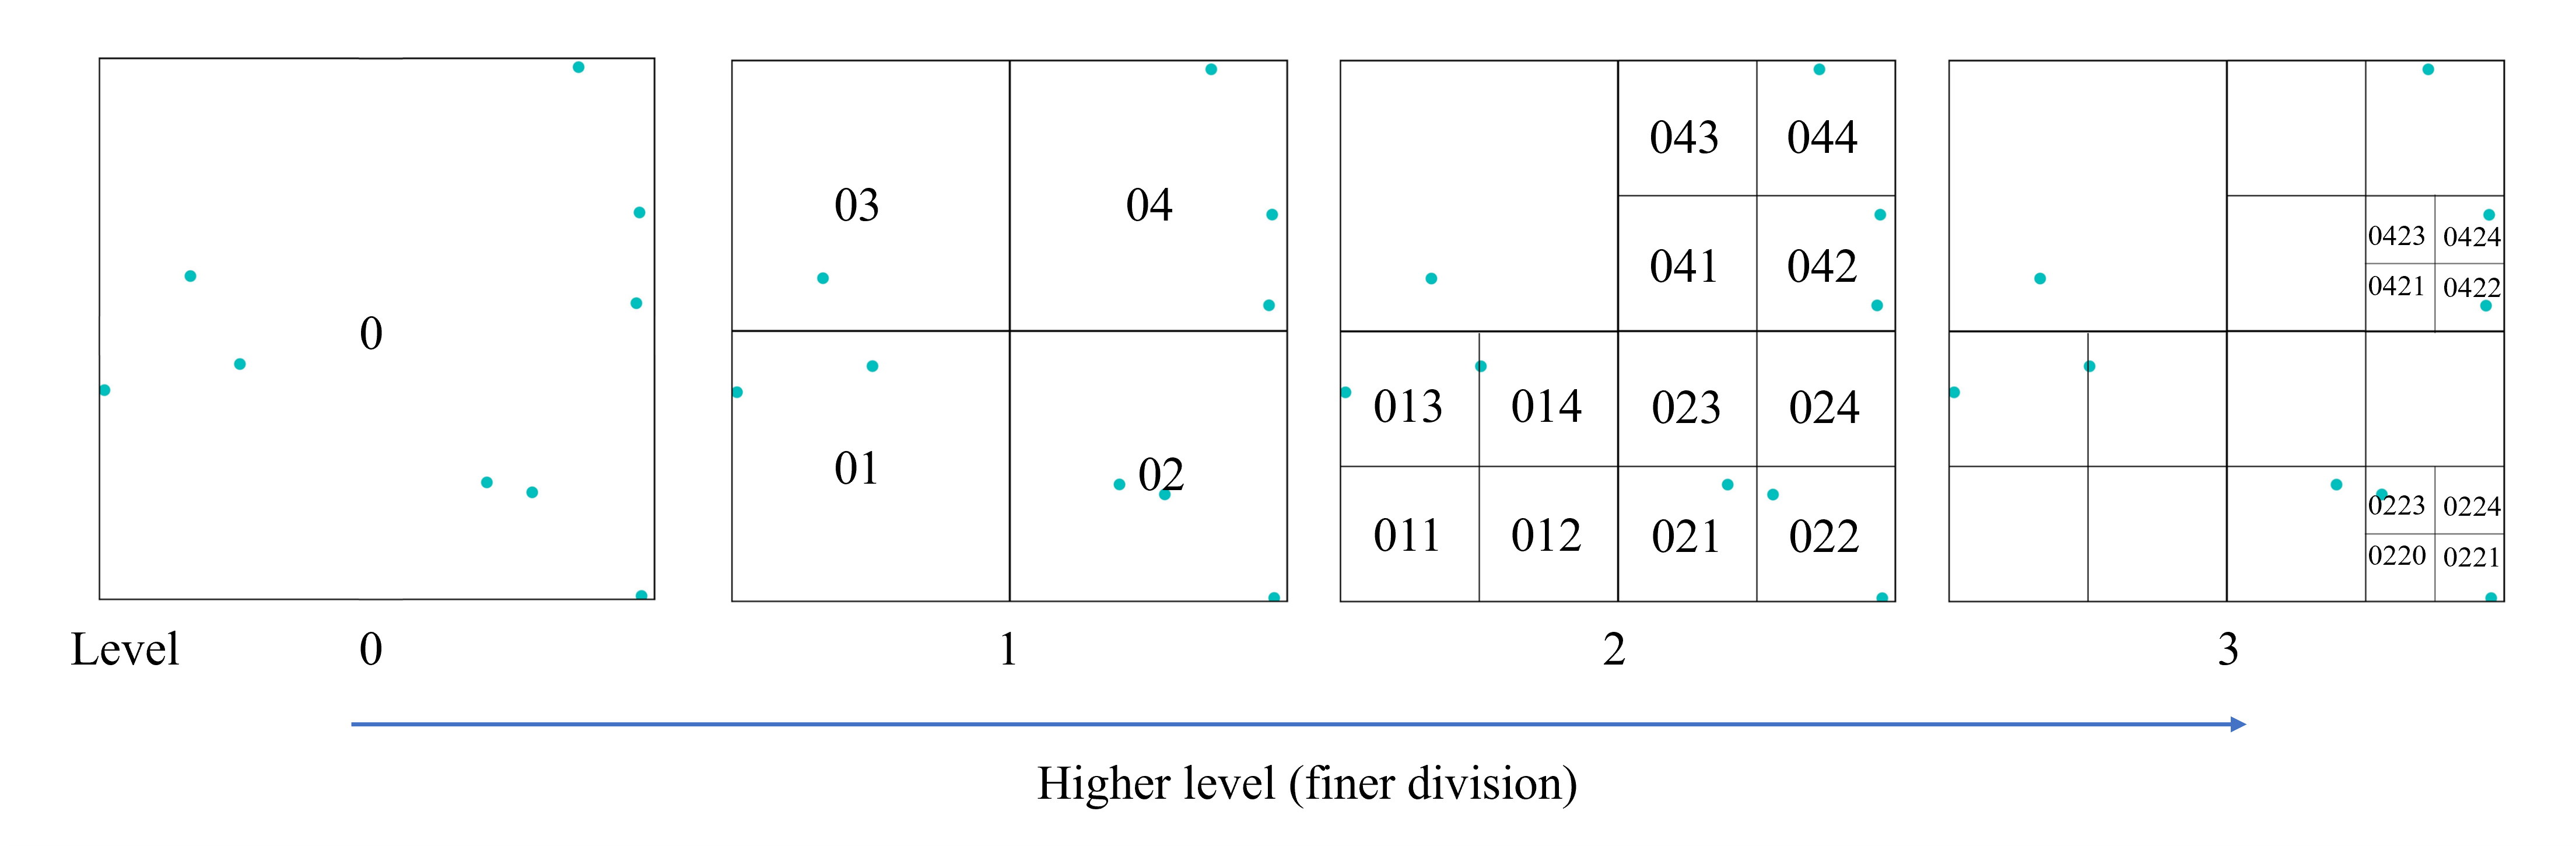
Figure 2: Barnes-Hut hierarchical-splitting. Each box is repeatedly divided into four quadrants until only one particle is left in each quadrant.

### 3.2.2 Potential Calculation
Having formed the hierarchical tree, we can now evaluate the potential starting from the lowest (coarser) level and advancing to higher (finer) levels if required. Consider a target particle shown in Fig \ref{fig: BH potential calc}. At the 0th level, box 0 represents all the 9 particles on the grid. The distance $R$ between the target and the c.o.m. of this source representation is compared to the width $s$ of a box at this level (e.g. 8 units at level 0). The value $s/R$ acts as a quantifier of whether a source group is sufficiently far away from a target that it can be approximated as a point mass. A threshold $\theta$ can be chosen such that if $s/R < \theta$, the source group is considered far enough and its point representation can be used. A common value used in practice is 1/2.
If $s/R < \theta$, the potential (between the target and the source group) is calculated directly and added to the total potential of the target. Otherwise, the potential is evaluated at the next level (children), where the sources will be represented by a higher number of smaller groups. This process is carried out recursively on the children of the boxes until the leaf box is reached (i.e. there is only 0 or 1 particle in the box).

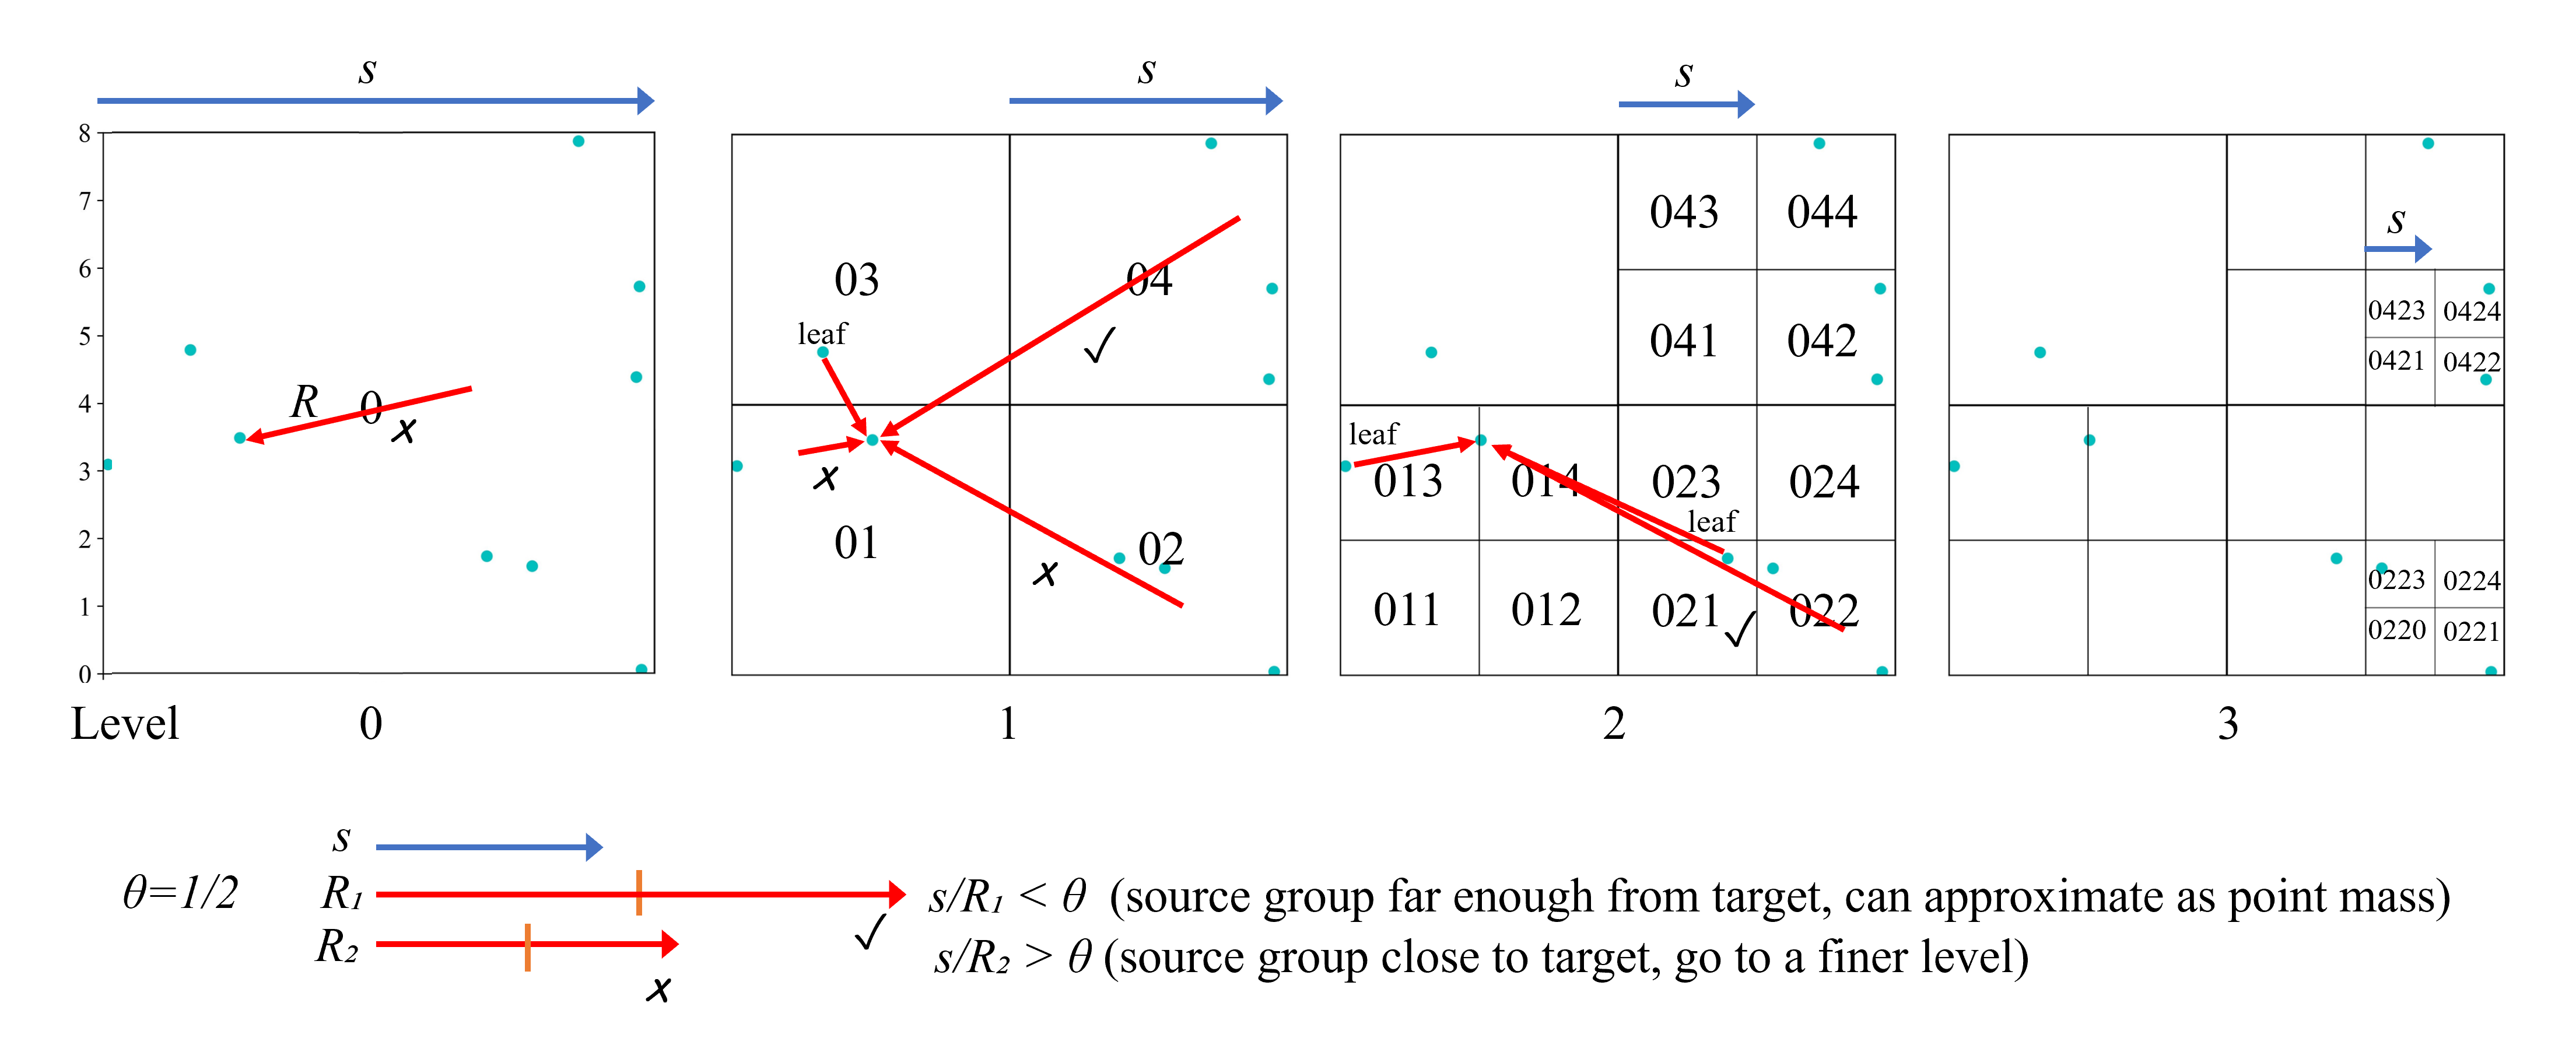
Figure 3: Evaluating the force on one target particle. A group of source particles may be treated as an effective point mass if the group is sufficiently far away.

#### Classes
The below code creates multiple classes: Grid, GridComplex, Point, Particle, Box, and BoxComplex.
The grid objects act as a "container" of the particles and a platform to display the particle distribution.
The particles objects will be attached to the grid
The Complex Classes are inherited from their "real counterpart" Classes, specifically designed for the FMM method.

In [4]:
class Grid():
    """Creates grid that acts as a "container" of the particles and a platform to 
    display the particle distribution. 
    Note that the grid can only contain particles having coordinates > 0. 
    Otherwise, shift all the particles until they are all > 0.
    """
    def __init__(self, size=16):
        self.size = size
        self.fig, self.ax = plt.subplots(figsize=(6,6))
        self.particles = []
        self.points = []
        self.rootbox = Box(coords=(size/2, size/2), size=size, ptcmax=1, grid=self)
        plt.close()

    def add_point(self, point):
        """Adds point/particle to grid automatically upon point/
        particle initialisation. 
        (see __init__ of Point Class)
        Makes sure that there is no negative-valued coordinate and that
        the coordinates are within the (square) size of the grid.
        """
        if type(point)==Particle:
            self.particles.append(point)
            if point.coords is not None:
                assert all(c>0 for c in point.coords), \
                    """Grid can only take particles with positive-valued
                    coordinates. Try shifting the origin of the particle(s)."""
                max_coord = max([c for c in point.coords])
                if max_coord > self.size:
                    self.size = max_coord
                    print(f"Grid size adjusted to {max_coord}")
        elif type(point)==Point:
            self.points.append(point)

    def create_particles(self, N, all_coords=None, all_q=None):
        if all_q is None:
            all_q = np.ones(N)*10
            print('All charges initialised to 10.')

        if all_coords is None:
            particles = [Particle(grid=self, q=q) for q in all_q]
        else:
            particles = [Particle(grid=self, coords=coords, q=q) for q, coords in zip(all_q, all_coords)]
        
        return particles

    def draw(self):
        self.ax.clear()
        self.ax.set_xlim(0, self.size)
        self.ax.set_ylim(0, self.size)      
        self.ax.set_xlabel(r'$x$')
        self.ax.set_ylabel(r'$y$')

        all_x = [particle.coords[0] for particle in self.particles]
        all_y = [particle.coords[1] for particle in self.particles]
        all_colours = [particle.colour for particle in self.particles]
        self.ax.scatter(all_x, all_y, color = all_colours)
        return self.fig

    def draw_squares(self, lvls, save=0):
        """Draws square grid at given level.
        Call grid.draw() first to include particles.
        """
        size = self.size
        fig, ax = self.fig, self.ax
        lw = 2
        for lvl in range(lvls+1):
            for i in range(1,4**lvl):
                ax.plot([0,size], [size/(2**lvl)*i]*2, color = 'k', linewidth=lw)
                ax.plot([size/(2**lvl)*i]*2, [0,size], color = 'k', linewidth=lw)
            lw *= 0.6
        ax.set_xlim(0, size)
        ax.set_ylim(0, size)      
        # ax.set_xticks([])      
        # ax.set_yticks([])
        if save:
            name = input('') + f' Grid level {lvls}' + '.jpg'
            fig.savefig(name, dpi=500)
        return fig
    
    def direct_sum(self):
        """
        Calculates the potential for each particle using direct summation method.
        Potential := Σ-(q/r), where q is the charge of the source particles and 
        r is the distance between the particle and the source particles. 
        The potential of each of the particles is stored in the phi attribute of 
        the particles.
        """
        self.clear_all_phi()
        for i, target in enumerate(self.particles):
            for source in (self.particles[:i] + self.particles[i+1:]):
                r = target.distance(source)
                target.phi -= (source.q)/r
    
    def direct_source_target(self, sources, targets):
        """Calculates the potential induced by a group of SOURCE particles, 
        evaluated at each of the TARGET particles, using direct summation method.

        Potential := Σ-(q/r), where q is the charge of the SOURCE particles and 
        r is the distance between the target and the source particles. 
        The potential evaluated at each of the TARGET particles is stored in the 
        phi attribute of the TARGET particles.
        Interactions within the source group and within the target group are ignored.
        Arguments:
            sources: list of source particles
            targets: list of target particles
        """
        self.clear_all_phi()
        for target in targets:
            for source in sources:
                r = target.distance(source)
                target.phi -= (source.q)/r

    def get_all_coords(self):
        return np.array([p.coords for p in self.particles])
    
    def get_all_phi(self):
        return [p.phi for p in self.particles]

    def clear_all_phi(self):
        for p in self.particles:
            p.phi = 0
    

class GridComplex(Grid):
    """Creates complex grid that acts as a "container" of the particles and a platform to 
    display the particle distribution.
    """
    def __init__(self, size=16):
        super().__init__(size)

    def add_point(self, point):
        """Adds point/particle to grid automatically upon point/
        particle initialisation. 
        (see __init__ of Point Class)
        
        Makes sure that there is no negative-valued coordinate 
        (x>0, y>0) for x+iy and that the coordinates are within the 
        (square) size of the grid.
        """
        if type(point)==Particle:
            self.particles.append(point)
        elif type(point)==Point:
            self.points.append(point)
        if point.coords is not None:
            r, i = point.coords.real, point.coords.imag
            if r<self.size and i<self.size:
                pass
            else:
                print(f'{type(point).__name__} {id(point)} out of grid')   
    
    def draw(self):
        self.ax.clear()
        self.ax.set_xlim(0, self.size)
        self.ax.set_ylim(0, self.size)      
        self.ax.set_xlabel(r'$x$')
        self.ax.set_ylabel(r'$y$')
        for ps in [self.particles, self.points]:
            if ps:
                r_i_c = [(p.coords.real, p.coords.imag, p.colour) for p in ps]
                all_x, all_y, all_colours = zip(*r_i_c)
                self.ax.scatter(all_x, all_y, color = all_colours)
        return self.fig

In [5]:
class Point():
    """Point object.

    Attributes
    ----------
    grid: the grid to which the point belongs
    q: charge of the particle
    coords: spatial coordinates of the particle
    phi: potential, initialised to 0
    """
    def __init__(self, grid, coords, colour = 'r'):
        self.grid = grid
        self.coords = coords
        self.grid.add_point(self) # The point is automatically added to the grid upon creation.
        self.colour = colour

    def distance(self, target_coords):
        """Returns (real) distance between the point and a target.
        The target can either be another object with a coords
        attribute or an array of coords.
        """    
        if hasattr(target_coords, 'coords'):
            target_coords = target_coords.coords
        r = target_coords-self.coords
        return np.linalg.norm(r)
    
    def coords_to_real(self):
        return self.coords.real, self.coords.imag


class Particle(Point):
    """Creates a particle with a "charge" (e.g. mass, electric charge) within a given grid.
    Its initial coordinates is randomised within the grid.
    grid: the grid to which the particle belongs
    q: charge of the particle
    coords: spatial coordinates of the particle
    phi: potential, initialised to 0
    """
    def __init__(self, grid, coords=None, q=10, colour="c"):
        super().__init__(grid, coords, colour)
        self.q = q
        self.phi = 0 # Initialise potential to 0
        # initialise with randomised coordinates if they are not provided.
        if coords is None:
            size = self.grid.size
            rand_x = size * np.random.random()
            rand_y = size * np.random.random()
            if type(self.grid) == GridComplex:
                self.coords = rand_x + 1j*rand_y
            else:
                self.coords = np.array((rand_x, rand_y))
        elif type(self.grid) == GridComplex:
            self.coords = coords
        else:
            try:
                _ = iter(coords)
                self.coords = np.array(coords)
            except TypeError:
                print('coords given not iterable')


In [6]:
class Box():
    """Elements that constitute a tree.

    Arguments
    ---------
    coords: center coordinates of the box.
    com: ΣmR/Σm (summed over all particles) m can be charge or mass
    ptcmax: maximum number of particles allowed in the box.
    """
    def __init__(self, coords, size=16, ptcmax=1, parent=None, grid=None):
        self.coords = np.array(coords)
        self.size = size
        self.ptcmax = ptcmax
        self.parent = parent
        if self.parent is not None:
            self.parent.children.append(self)
        self.children = []
        self.grid = grid
        if grid is None:
            self.grid = self.parent.grid
        self.particles = []
        self.com_M = 0
        self.com_R = np.array(self.coords)

    def quadrant_split(self):
        """Creates quadrant (child) boxes centered at parent box.
         Q2 | Q3
        ----+----
         Q0 | Q1
        """
        assert len(self.children)==0, f"Current box already has children."
        x, y = self.coords
        size = self.size/2
        q_i = np.arange(4)
        q_xs = (q_i%2 * size) - size/2 + x 
        q_ys = (q_i//2 * size) - size/2 + y
        q_children = [Box((qx, qy), size, ptcmax=self.ptcmax, parent=self) for qx, qy in zip(q_xs, q_ys)]
        return q_children
    
    def get_child_quadrant(self, particle):
        """ Locates the child quadrant a particle belongs to and returns it.
        quadrant_i: 0 or 1 or 2 or 3
         Q2 | Q3
        ----+----
         Q0 | Q1
        """
        assert self.children, f"Current box has no children. Use quadrant_split() to obtain children first."
        x, y = particle.coords
        x_c, y_c = self.coords
        quadrant_i = [[0,2],[1,3]][int(x > x_c)][int(y > y_c)] # 0|1|2|3
        return self.children[quadrant_i]

    def add_com(self, particle):
        # self.particles.append(particle) 
        # - I guess there is no point in adding the child itself as 
        # a) the com will be added
        # b) individual child are only needed at the external box level
        M, R = self.com_M, self.com_R
        m, r = particle.q, particle.coords
        self.com_R = (M*R + m*r)/(M+m)
        self.com_M += m
    
    def print_step(self, particle, box, add_com=0, add_ptc=0):
        if add_com:
            print(f'COM contribution of particle {id(particle)} added to box {id(box)}.')
        elif add_ptc:
            print(f'Particle {id(particle)} added to box {id(box)}.')


class BoxComplex():
    """Elements that constitute a tree.

    Arguments
    ---------
    coords: center coordinates of the box.
    """
    def __init__(self, coords, size=16, ptcmax=10, parent=None, grid=None, p=6):
        self.coords = coords
        self.size = size
        self.ptcmax = ptcmax
        self.parent = parent
        if self.parent is not None:
            self.parent.children.append(self)
        self.children = []
        self.grid = grid
        if grid is None and self.parent is not None:
            self.grid = self.parent.grid
        self.p = p
        self.S2M_coeffs = np.zeros(p+1)
        self.M2L_coeffs = np.zeros(p+1)
        self.particles = []

    def quadrant_split(self):
        """Creates quadrant (child) boxes centered at parent box.
         Q2 | Q3
        ----+----
         Q0 | Q1
        """
        assert len(self.children)==0, f"Current box already has children."
        x, y = self.coords.real, self.coords.imag
        size = self.size/2
        q_i = np.arange(4)
        q_xs = (q_i%2 * size) - size/2 + x 
        q_ys = (q_i//2 * size) - size/2 + y
        q_children = [BoxComplex(qx +1j*qy, size, ptcmax=self.ptcmax, parent=self, p=self.p) for qx, qy in zip(q_xs, q_ys)]
        return q_children
    
    def coords_to_real(self):
        return self.coords.real, self.coords.imag

#### Functions
Functions required for the BH and FMM code are defined below. Examples of how to use them will be demonstrated in the implementation sections.

In [7]:
# real functions (for BH)
def potential(source, target_coords):
    """Returns potential at a target induced by a source, using 
    real coords.
    
    Arguments
    ---------
    source: object with coords and q attribute.
    target: array of coords, or object with coords attrtibute.
    form:
    φ := q*log(|r|) where r is the target-source distance.
    """
    if hasattr(target_coords, 'coords'):
        target_coords = target_coords.coords
    return source.q * np.log(source.distance(target_coords))

def grid_direct_sum(grid):
    """Calculates the real potential generated by all particles in a grid evaluated
    at where all the particles are by direct summation.

    The potential of each of the particles is stored in the phi attribute of 
    the particles.
    """
    grid.clear_all_phi()
    particles = grid.particles
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            target.phi += potential(source, target.coords)

def direct_source_target(sources, targets):
    """Calculates the potential induced by a group of SOURCE particles, 
    evaluated at each of the TARGET particles, using direct summation method.

    The potential evaluated at each of the TARGET particles is stored in the 
    phi attribute of the TARGET particles.

    Interactions within the source group and within the target group are ignored.
    
    Arguments:
    ----------
        sources: list of source particles
        targets: list of target particles (phi attribute will be updated)
    """
    for target in targets:
        for source in sources:
            target.phi += potential(source, target.coords)

def boxsize_to_level(boxsize, gridsize):
    """Converts boxsize to the level it belongs to."""
    return int(np.log2(gridsize/boxsize))

In [8]:
# BH functions
def bh_tree_insert_particle(particle, box, counter=0):
    """Inserts a particle into a box recursively into a tree structure.
    """
    box.add_com(particle)
    # box.print_step(particle, box, add_com=1)

    if len(box.particles) < box.ptcmax: # if there is vacancy
        box.particles.append(particle)
        # box.print_step(particle, box, add_ptc=1)
    elif box.children: # children exists (and box full)
        # print(f'box {id(box)} full, children exist.')
        child_box = box.get_child_quadrant(particle)
        bh_tree_insert_particle(particle, child_box, counter=counter)
    else: # no children (and box full)
        # print(f'box {id(box)} full, creating children.')
        particles = box.particles + [particle]
        box.quadrant_split()
        child_boxes = [box.get_child_quadrant(particle) for particle in particles]
        for particle, child_box in zip(particles, child_boxes):
            bh_tree_insert_particle(particle, child_box, counter=counter)

def bh_create_tree(grid, particles):
    """Constructs the tree structure required for the BH method."""
    rootbox = grid.rootbox
    assert len(rootbox.children)==0, \
            f"Root box already has a children. Start with a new tree."
    for p in particles:
        # print('New particle')
        bh_tree_insert_particle(p, rootbox)
        # print()

def bh_calc_at_particle(particle, box, theta=0.5):
    """Calculates the potential induced by a box evaluated at a particle's location 
    using the BH allgorithm.
    """
    s = box.size
    r = particle.distance(box.com_R)
    if r == 0: # the particle itself
        return
    if s/r < theta: # box far
        # print('box far')
        # particle.phi -= box.com_M/r # old potential
        particle.phi += box.com_M*np.log(r)
        # print(f'Added com contribution from box {id(box)}.')
    elif box.children: # box near, children exist
        # print('box near')
        for child_box in box.children:
            if child_box.particles: # only evaluate non-empty
                bh_calc_at_particle(particle, child_box, theta)
    else: # box near, no children
        # print('box near no child')
        sources = [p for p in box.particles if p is not particle]
        target = [particle]
        direct_source_target(sources, targets = target)
        # print(f'Added contributions from sources {[id(s) for s in sources]} in box {id(box)}.')

def bh_calc_phi(grid, theta=0.5):
    """Iterates through the whole grid to calculate the potential of every particle"""
    rootbox = grid.rootbox
    grid.clear_all_phi()
    for particle in grid.particles:
        bh_calc_at_particle(particle, rootbox, theta)

def find_bh_tree_depth(box, gridsize):
    """Finds maximum depth of a BH tree"""
    depth = 0
    if box.children:
        for child in box.children:
            depth = max(depth, find_bh_tree_depth(child, gridsize))
        return depth + 1
    else:
        return 0

In [9]:
# complex functions (for FMM)
def potential_complex(source, target_coords):
    """Returns potential at a target induced by a source, using 
    complex coords.
    
    Arguments
    ---------
    source: object with coords and q attribute.
    target: complex number, or object with coords attrtibute.
    form:
    φ := q*log(z-z0) where z and z0 are the coordinates of the
    target and source respectively
    """
    if hasattr(target_coords, 'coords'):
        target_coords = target_coords.coords
    return source.q * np.log(target_coords-source.coords)

def grid_direct_sum_complex(grid):
    """Calculates the complex potential generated by all particles in a grid evaluated
    at where all the particles are by direct summation.

    The potential of each of the particles is stored in the phi attribute of 
    the particles.
    """
    grid.clear_all_phi()
    particles = grid.particles
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            target.phi += potential_complex(source, target.coords)

def direct_sum_complex(particles):
    """Calculates the potential for each particle by direct summation.

    φ := q*log(z-z0) where z and z0 are the coordinates of the
    target and source respectively.
    The potential of each of the particles is added to the phi attribute of 
    the particles.

    This can be used for all particles in existance, or just for a subset 
    of particles.
    """
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            target.phi += potential_complex(source, target.coords)

def direct_source_target_complex(sources, targets):
    """Calculates the potential induced by a group of SOURCE particles, 
    evaluated at each of the TARGET particles, using direct summation method.

    The potential evaluated at each of the TARGET particles is stored in the 
    phi attribute of the TARGET particles.

    Interactions within the source group and within the target group are ignored.
    
    Arguments:
    ----------
        sources: list of source particles
        targets: list of target particles (phi attribute will be updated)
    """
    for target in targets:
        for source in sources:
            target.phi += potential_complex(source, target.coords)

In [10]:
# FMM functions
def four_fractal(lvl):
    """Returns array of integer in a specific format to help in the indexing of FMM boxes.
    """
    if lvl>0:
        a0 = np.array([[0,1],[2,3]])
        i_4 = np.ones((2,2))
        a = np.array([[0,1],[2,3]])
        for n in range(1, lvl):
            N = int(2**n)
            i_4n = np.ones((N,N)) * 4**n
            a = np.kron(a0,i_4n) + np.kron(i_4,a)
        return a.T.astype('i').tolist()
    return None

def bin_coords_to_ij(items, lvl):
    grid = items[0].grid
    all_coords = [(item.coords.real, item.coords.imag) for item in items]
    all_coords_x, all_coords_y = [coord for coord in zip(*all_coords)]
    bin_is = np.digitize(all_coords_x, np.arange(0, grid.size, grid.size/(2**lvl)))-1
    bin_js = np.digitize(all_coords_y, np.arange(0, grid.size, grid.size/(2**lvl)))-1
    return bin_is, bin_js

def construct_tree_fmm(lvls, grid, ptcmax, p):
    tree = [[BoxComplex(grid.size/2+1j*grid.size/2, size=grid.size, ptcmax=ptcmax, grid=grid,p=p)]]
    crowded = False
    crowd = {key:[] for key in ('coords', 'nptcs')}
    # empty tree
    if lvls > 0:
        for lvl in range(1, lvls+1):
            next_lvl = []
            for i in range(len(tree[lvl-1])):
                next_lvl.extend(tree[lvl-1][i].quadrant_split())
            tree.append(next_lvl)
    # insert particles into leaf level
    idx_helpers = [four_fractal(lvl) for lvl in range(lvls+1)]
    bin_is, bin_js = bin_coords_to_ij(grid.particles, lvls)
    for ptc, bin_i, bin_j in zip(grid.particles, bin_is, bin_js):
        tree[lvls][idx_helpers[lvls][bin_i][bin_j]].particles.append(ptc)
    for leaf_box in tree[lvls]:
        if len(leaf_box.particles) >= ptcmax:
            crowd['coords'].append(leaf_box.coords)
            crowd['nptcs'].append(len(leaf_box.particles))
    if crowd['nptcs']:
        print(f"Leaf box(es) centered at {crowd['coords']} too crowded, it has {crowd['nptcs']} particles. Try increasing 'lvls'.")
        crowded = True

    return tree, idx_helpers, crowded

def direct_neighbours(box, tree, idx_helpers, inclself=True):
    """Returns the direct neighbours of a given box."""
    lvl = int(np.log2(box.grid.size/box.size))
    same_lvl_boxes = tree[lvl]
    idx_helper = idx_helpers[lvl]
    max_ij = int(2**lvl)-1
    box_i, box_j = bin_coords_to_ij([box], lvl)

    dir_neighs = []
    irange = range(int(max(0, box_i-1)), int(min(box_i+2, max_ij+1)))
    jrange = range(int(max(0, box_j-1)), int(min(box_j+2, max_ij+1)))
    for i in irange:
        for j in jrange:
            dir_neighs.append(same_lvl_boxes[idx_helper[i][j]])
    if inclself:
        return dir_neighs
    else:
        dir_neighs.remove(box)
        return dir_neighs

def interaction_list(box, tree, idx_helpers):
    """Returns the interaction list of a given box."""
    lvl = int(np.log2(box.grid.size/box.size))
    same_lvl_boxes = tree[lvl]
    idx_helper = idx_helpers[lvl]
    max_ij = int(2**lvl)-1
    box_i, box_j = bin_coords_to_ij([box], lvl)
    i_odd, j_odd = (box_i%2 != 0), (box_j%2 != 0)
    i_low, j_low = box_i-2-i_odd, box_j-2-j_odd
    i_upp, j_upp = i_low+6, j_low+6
    irange = range(int(max(0, i_low)), int(min(i_upp, max_ij+1)))
    jrange = range(int(max(0, j_low)), int(min(j_upp, max_ij+1)))

    interaction_list = []
    for i in irange:
        for j in jrange:
            interaction_list.append(same_lvl_boxes[idx_helper[i][j]])

    dir_neighs = direct_neighbours(box, tree, idx_helpers, inclself=1)
    for dn in dir_neighs:
        interaction_list.remove(dn)
    
    return interaction_list


In [11]:
# FMM core calculations
def sum_4_7(a_k, source_centre, target_coords):
    """
    for Broadcasting purposes:
    k-varying terms: [None, :] (power of multipole)
    i-varying terms: [:, None] (particle index)
    sum: 
        axis = 0: sum over particles
        axis = 1: sum over powers
    a_0: number
    a_k: array
    sum returns potential evaluated at target coordinates
    """
    
    p = len(a_k)-1
    target_coords = np.array(target_coords)
    k_k = np.arange(1,p+1) #[None, :]
    z_t = target_coords-source_centre.coords
    power_terms = (1/(z_t)[:, None] ** k_k)
    return a_k[0]*np.log(z_t) + np.matmul(power_terms, a_k[1:])

def S2M_coeff(particles, source_centre, p=6):
    """S2M coefficients (4.7) i.e. a_k given centre
    for Broadcasting purposes:
    k-varying terms: [None, :] (power of multipole)
    i-varying terms: [:, None] (particle index)
    sum: 
        axis = 0: sum over particles
        axis = 1: sum over powers
    a_0: number
    a_k: array
    """
    if particles:
        q_i = np.array([particle.q for particle in particles])[:, None]
        z_i = np.array([(particle.coords - source_centre.coords) for particle in particles])[:, None]
        k_k = np.arange(1,p+1) #[None, :]
        
        a_0 = sum(q_i)[0]
        a_k = np.sum(-q_i*(z_i**k_k)/k_k, axis = 0)
        a_k = np.insert(a_k, 0, a_0)
        return a_k
    return np.zeros(p+1)

def M2M_translation(a_k, source_centre_old, source_centre_new):
    """M2M translation (4.15) (old source centre to new source centre)
    a_0, a_k --> a_0, b_l
    a_0: number
    a_k, b_l: array
    """
    # a_k_all = np.insert(a_k, 0, a_0)
    z_0 = source_centre_old.coords - source_centre_new.coords
    b_l = np.array([sum([a_k[k] * z_0**(l-k) * math.comb(l-1, k-1) 
                         for k in range(1, l+1)]) 
                         for l in range(1, len(a_k))])
    l_l = np.arange(1, len(a_k))
    b_l = b_l - a_k[0]*(z_0**l_l)/l_l
    b_l = np.insert(b_l, 0, a_k[0])
    return b_l

def M2L_coeff(a_k, source_centre, target_centre):
    """takes "S2M coefficients", returns b_l (M2L coefficients) (4.18) 
    not a_k from source"""
    p = len(a_k)-1
    # a_k_all = np.insert(a_k, 0, a_0)
    z_0 = (source_centre.coords - target_centre.coords)
    k_k = np.arange(1,p+1)
    b_0 = a_k[0] * np.log(-z_0) + np.sum(a_k[1:] * (-1/z_0)**k_k)
    b_l = np.array(
        [- a_k[0]/l/(z_0**l)
         + (sum([a_k[k] * (-1/z_0)**k * math.comb(l+k-1, k-1) for k in range(1, p+1)])/z_0**l)
         for l in range(1, p+1)]
        )
    b_l = np.insert(b_l, 0, b_0, axis=0)
    return b_l

def sum_local(b_l, target_centre, target_coords):
    """(4.17) Although sum_4_7 provides the same multi-target evaluation, it requires
    evaluation of the a_0, a_k coeffs for each of the targets.
    sum_4_17 only uses the target info at the end of the"""
    p = len(b_l)-1
    target_coords = np.array(target_coords)
    l_l = np.arange(0,p+1) #[None, :]
    z_t = target_coords - target_centre.coords
    power_terms = (z_t)[:, None] ** l_l
    return np.matmul(power_terms, b_l)

def L2L_translation(a_k, target_centre_old, target_centre_new):
    """L2L translation (4.22) (old target centre to new target centre)
    a_k (old) --> b_k (new)
    a_k: array
    this is an exact expression hence shifting to new origin wouldn't affect the results
    """
    p = len(a_k)-1
    b_k = np.copy(a_k)
    z_0 = target_centre_old.coords - target_centre_new.coords
    for j in range(0, p):
        for k in range(p-j-1, p):
            b_k[k] = b_k[k] - z_0*b_k[k+1]
    return b_k

In [12]:
# FMM steps - uses FMM core calculations
def fmm_step_S2M(tree, lvls, p):
    """Finds source representation.
    Information flow: source particles -> leaf child box
    """
    for child in tree[lvls]:
        child.S2M_coeffs = S2M_coeff(child.particles, child, p)

def fmm_step_M2M(tree, lvls):
    """Transfers source representation. 
    Information flow: child -> parent
    """
    for lvl in range(lvls-1, 1, -1):
        for par in tree[lvl]:
            for child in par.children:
                par.S2M_coeffs = par.S2M_coeffs + M2M_translation(child.S2M_coeffs, child, par)

def fmm_step_M2L(box, tree, idx_helpers):
    """Evaluates target representation from (far) source representation. 
    Information flow: far source (i.e. interaction list) -> target
    """
    for far_source_box in interaction_list(box, tree, idx_helpers):
        box.M2L_coeffs = box.M2L_coeffs + M2L_coeff(far_source_box.S2M_coeffs, far_source_box, box)

def fmm_step_L2L(box):
    """Transfers target representation. 
    Information flow: parent -> child
    """
    for child in box.children:
        child.M2L_coeffs = child.M2L_coeffs + L2L_translation(box.M2L_coeffs, box, child)

def fmm_step_L2P(leaf_box):
    """Uses target representation to evaluate the potential.
    Information flow: leaf child box -> target particles
    """
    target_coords = [ptc.coords for ptc in leaf_box.particles]
    phis = sum_local(leaf_box.M2L_coeffs, leaf_box, target_coords)
    for phi, ptc in zip(phis, leaf_box.particles):
        ptc.phi += phi

def fmm_step_P2P(leaf_box, tree, idx_helpers):
    """Evaluates potential directly from nearby sources.
    Information flow: 
    neighbouring boxes + leaf child box sources -> leaf child box targets
    """
    sources = []
    for neigh_leaf in direct_neighbours(leaf_box, tree, idx_helpers, inclself=0):
        sources.extend(neigh_leaf.particles)
    direct_source_target_complex(sources, leaf_box.particles)
    direct_sum_complex(leaf_box.particles)

def fmm_calc_phi(tree, idx_helpers, lvls, p):
    """Combines all the fmm_steps.
    The resulting potentials are stored in the phi attribute of the particles
    1. S2M: Finds source representation.
        (source particles -> leaf child box)
    2. M2M: Transfers source representation. 
        (child -> parent)
    3. M2L: Evaluates target representation from (far) source representation. 
        (far source -> target)
    4. L2L: Transfers target representation. 
        (parent -> child)
    5. L2P: Uses target representation to evaluate the potential. 
        (leaf child box -> target particles)
    6. P2P: Evaluates potential directly from nearby sources.
        (neighbouring boxes + leaf child box sources -> leaf child box targets)
    """
    print()
    print('start of fmm calc')
    very_start = time.time()

    keys = ['S2M', 'M2M', 'M2L', 'L2L', 'L2P', 'P2P']
    times = {key:[] for key in keys}

    #1
    tic = time.perf_counter()
    fmm_step_S2M(tree, lvls, p)
    toc = time.perf_counter()
    times[keys[0]].append(toc-tic)
    # print(f'{keys[0]} ed.')
    # print('Time elapsed:', time.time() - very_start)

    #2
    tic = time.perf_counter()
    fmm_step_M2M(tree, lvls)
    toc = time.perf_counter()
    times[keys[1]].append(toc-tic)
    # print(f'{keys[1]} ed.')
    # print('Time elapsed:', time.time() - very_start)

    time_M2L = 0
    time_L2L = 0
    for lvl in range(2, lvls+1):
        for box in tree[lvl]:
            #3
            tic = time.perf_counter()   
            fmm_step_M2L(box, tree, idx_helpers)
            toc = time.perf_counter()
            time_M2L += toc-tic

            if lvl >= lvls:
                continue

            #4
            tic = time.perf_counter()   
            fmm_step_L2L(box)
            toc = time.perf_counter()
            time_L2L += toc-tic
    
    times[keys[2]].append(time_M2L)
    # print(f'{keys[2]} ed.')
    times[keys[3]].append(time_L2L)
    # print(f'{keys[3]} ed.')
    # print('Time elapsed:', time.time() - very_start)
    
    time_L2P = 0
    time_P2P = 0
    for leaf_box in tree[-1]:
        #5
        tic = time.perf_counter()   
        fmm_step_L2P(leaf_box)
        toc = time.perf_counter()
        time_L2P += toc-tic

        #6
        tic = time.perf_counter()   
        fmm_step_P2P(leaf_box, tree, idx_helpers)
        toc = time.perf_counter()
        time_P2P += toc-tic
    
    times[keys[4]].append(time_L2P)
    # print(f'{keys[4]} ed.')
    times[keys[5]].append(time_P2P)
    # print(f'{keys[5]} ed.')
    print('Time elapsed:', time.time() - very_start)
    print('end of fmm calc')
    # print()
    return times

## 3.3 Implementation: Time Complexity and Error Analysis
### 3.3.1 Time Complexity - Varying N
To obtain an expression for the time complexity for both the tree construction and potential calculation, we consider a grid in the limit of large $N$ (number of particles) uniformly distributed on the grid, using $\theta=0.5$. 
The total number of leaf boxes in a tree is in the order of $N$ (number of leaf boxes $=N$ if there is exactly one particle for all leaf boxes; $>N$ if there are some empty leaf boxes). If there are $L$ levels in total, assuming a uniform distribution, $4^L = N$ as $4^l$ is the number of boxes present at a given level $l$ in a uniform distribution. Any given particle is required to have their mass and location information updated to a box at any given level (hence $L$ updates for a particle). Thus, the total number of operations to construct the tree $\propto NL \propto N \log_{4}N\propto N\log N.$

Consider a target located in the centre of the grid (see Fig \ref{fig: BH nlogn explain}). At level 3 and beyond, the target is always far ($s/R>\theta$) from 36 boxes at any given level, and hence an effective point source representation can be used to deal with those boxes. This pattern will repeat until the finest level $L$ which contains only one particle per box. Hence, the total number of box-target interactions is $36 \times (L-3) \propto L.$ Hence the total number of box-target interactions $\propto L = \log_{4}N$ for the central target. A similar analysis can be done for a target particle located at a corner of the grid to obtain a similar scaling relation. There are $N$ target particles in total, hence the total number of operations to evaluate the potentials at all particles $\propto NL \propto N\log N$. 



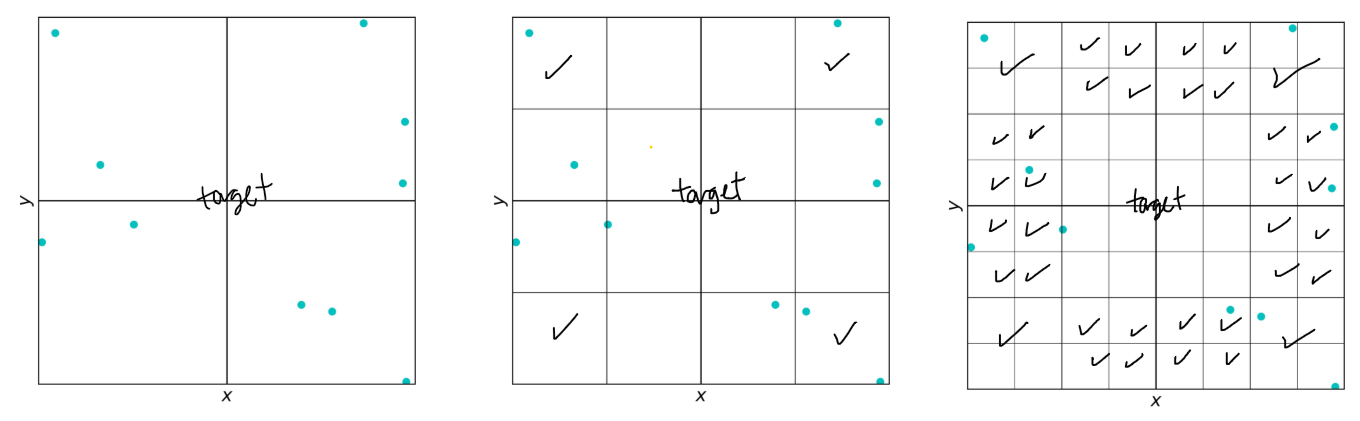
Figure 4a: For a given target, each level sweeps out a fixed number of boxes, leaving a smaller structure. E.g. 1: for a target located at the centre of the grid, from level 3 onwards, every level sweeps out 36 boxes, leaving a self-repeating structure of smaller unswept boxes.

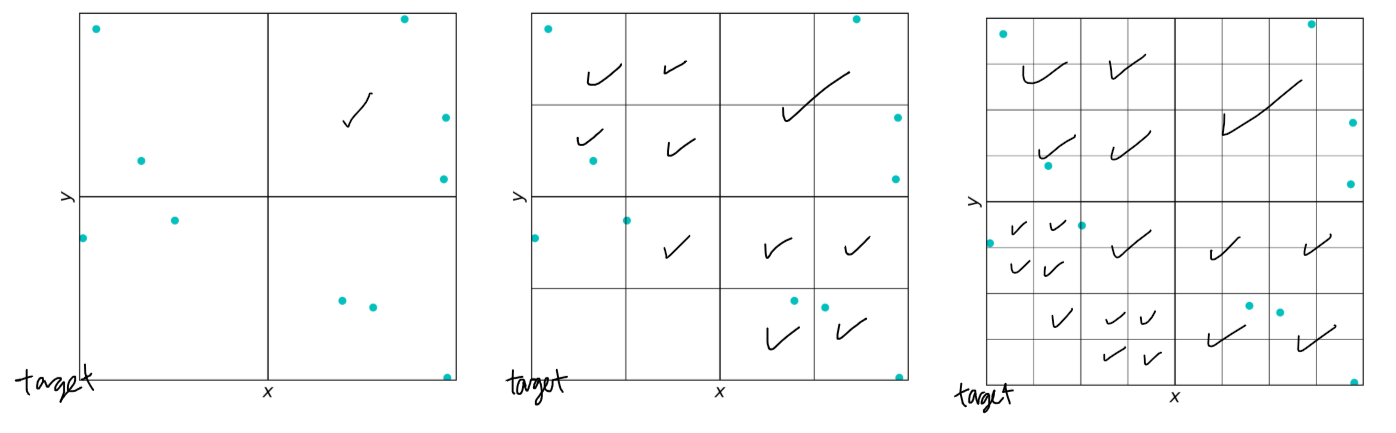
Figure 4b: E.g. 2: for a target located at the corner, from level 2 onwards, every level sweeps out 9 boxes, leaving a self-repeating structure of smaller unswept boxes.

The below code runs the BH code for different $N$ (number of particles). $\theta$ is fixed at 0.5. The timing and error as a function of $N$ will be examined.

Timer elapsed reset.
n = 100, theta = 0.5
BH calculated.
Direct calculated.
Timer elapsed reset.
n = 237, theta = 0.5
BH calculated.
Direct calculated.
Timer elapsed reset.
n = 562, theta = 0.5
BH calculated.
Direct calculated.
Timer elapsed reset.
n = 1333, theta = 0.5
BH calculated.
Direct calculated.
Timer elapsed reset.
n = 3162, theta = 0.5
BH calculated.
Direct calculated.


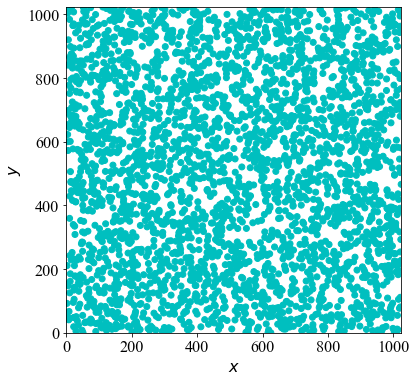

In [42]:
# loop BH over different N
N_range = np.logspace(2,3.5,5).astype('i')
keys = ['create_tree', 'bh_calc', 'direct_sum']
times = {key:[] for key in keys}
depths = []
max_errs = []
all_data = []

for n in N_range:
    very_start = time.time()
    print("Timer elapsed reset.")
    theta = 0.5
    print(f"n = {n}, theta = {theta}")

    np.random.seed(4)
    grid = Grid(size=1024)
    all_coords = [i for i in range(n)]
    all_q = np.random.random(len(all_coords))*10+50
    all_particles = grid.create_particles(len(all_coords), all_coords=None, all_q=all_q)
    # print('Grid and particles initialised.')
    # print('Time elapsed:', time.time() - very_start)

    tic = time.perf_counter()
    bh_create_tree(grid, grid.particles)
    toc = time.perf_counter()
    times[keys[0]].append(toc-tic)
    # print('Time elapsed:', time.time() - very_start)

    depth = find_bh_tree_depth(grid.rootbox, grid.size)
    depths.append(depth)
    # print("BH tree depth:", depth)
    # print('Time elapsed:', time.time() - very_start)

    tic = time.perf_counter()
    bh_calc_phi(grid, theta)
    toc = time.perf_counter()
    times[keys[1]].append(toc-tic)
    print('BH calculated.')
    # print('Time elapsed:', time.time() - very_start)

    bh = np.array(grid.get_all_phi())
    # print('Time elapsed:', time.time() - very_start)

    tic = time.perf_counter()
    grid_direct_sum(grid)
    toc = time.perf_counter()
    times[keys[2]].append(toc-tic)
    print('Direct calculated.')
    # print('Time elapsed:', time.time() - very_start)

    exact = np.array(grid.get_all_phi())
    bh_errs = (bh-exact)/exact

    data = abs(bh_errs)
    all_data.append(data)
    max_errs.append(max(data))
    # # if zeros exist:
    # if any(data==0):
    #     tot = len(data)
    #     data = data[data!=0]
    #     tot_no0 = len(data)
    #     # print(f'Dropped {tot-tot_no0} values that are 0.')

    # # create logspace bins
    # minexpnt = np.floor(np.log10(min(data)))
    # maxexpnt = np.ceil(np.log10(max(data)))
    # bins = np.logspace(minexpnt, maxexpnt, 20)

    # # create histogram with logscale bins
    # plt.hist(data, bins=bins, log=True)
    # plt.xscale('log')
    # plt.yscale('linear')
    # # plt.show()

grid.draw()

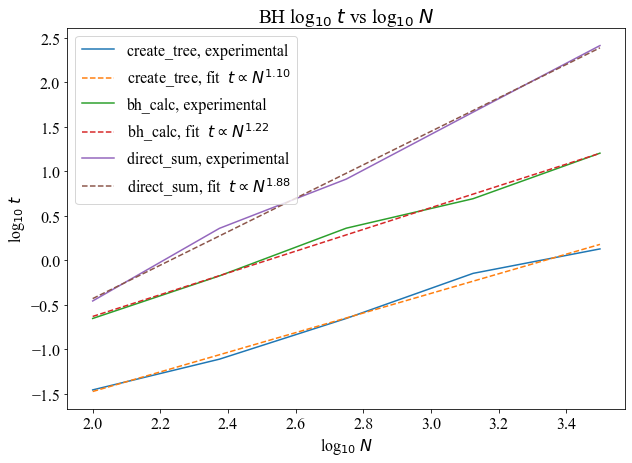

In [46]:
# t vs N
xlabel = 'N_range'
x = eval(xlabel)
fig, ax = plt.subplots(figsize = (10,7))
excluded_keys = ()
step_keys = [key for key in keys if key not in excluded_keys]
for i in range(len(step_keys)):
    y = np.array(times[step_keys[i]])
    X = np.log10(x[x!=0])
    Y = np.log10(y[x!=0])
    a, b = np.polyfit(X, Y, 1)
    ax.plot(X, Y, label = f'{keys[i]}, experimental')
    ax.plot(X, a*X+b, label=f'{keys[i]}, fit  $t \propto N^{{{a:.2f}}}$', linestyle='--')

plt.legend(loc='upper left')
ax.set_xlabel('log$_{10}$ $N$')
ax.set_ylabel('log$_{10}$ $t$')
title = f'BH log$_{{{10}}}$ $t$ vs log$_{{{10}}}$ ${xlabel[0]}$'
ax.set_title(title)
plt.show()
# plt.savefig(title + '.jpg', dpi=300)

A calculation by direct summation was run alongside the BH code. As expected, the time complexity of the direct summation approximately scales as $O(N^2)$. The labels create\_tree and bh\_calc correspond to the timings for BH tree construction and the potential calculation. Both of the BH codes scales slightly above $O(N^1)$ when fitted against a power law  which is expected for a $O(NlogN)$ complexity.

### 3.3.2 Error - Varying N
The error is calculated as the fractional difference between the calculations by direct summation (exact) and BH code (approximation). The errors ranges around $10^{-4}$ to $10^{-8}$ of the exact value for all values of N. Only the maximum value is shown in the below graph as that represents the actual precision.
The errors seem to reduce as $N$ increases. It should be noted that the particles are randomly distributed within the square grid (with a uniform probability density). This could be due to the averaging effect of a large number of particles making the c.o.m. approximation closer to the exact value.

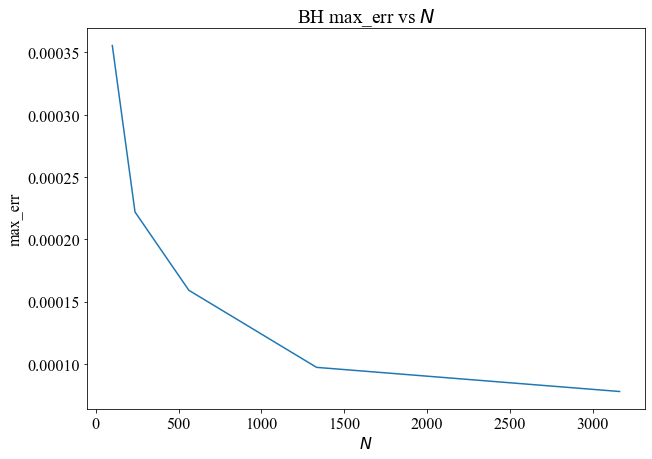

In [52]:
# max_err vs N
xlabel = 'N_range'
x = eval(xlabel)
fig, ax = plt.subplots(figsize = (10,7))
excluded_keys = ()
y = np.array(max_errs)
# X = np.log10(x[x!=0])
# Y = np.log10(y[x!=0])
# a, b = np.polyfit(X, Y, 1)
ax.plot(x, y)

ax.set_xlabel('$N$')
ax.set_ylabel('max_err')
title = f'BH max_err vs ${xlabel[0]}$'
ax.set_title(title)
plt.show()
# plt.savefig(title + '.jpg', dpi=300)

### 3.3.3 Time Complexity - Varying $\theta$
$\theta$ represents the threshold to determine whether a source group is determined to be sufficiently far ($s/R<\theta$) that it can be approximated as a point mass. In the limit of $\theta = 0$, no source groups can be considered far away and hence the code reduces
to direct summation. On the other hand, when $\theta$ is large, every mass is far and the only remaining interaction will be that between each particle and the c.o.m. of the entire system.

Timer elapsed reset.
n = 100, theta = 0.0
BH calculated.
Direct calculated.
Timer elapsed reset.
n = 100, theta = 0.5
BH calculated.
Direct calculated.
Timer elapsed reset.
n = 100, theta = 1.0
BH calculated.
Direct calculated.
Timer elapsed reset.
n = 100, theta = 1.5
BH calculated.
Direct calculated.
Timer elapsed reset.
n = 100, theta = 2.0
BH calculated.
Direct calculated.
Timer elapsed reset.
n = 100, theta = 2.5
BH calculated.
Direct calculated.
Timer elapsed reset.
n = 100, theta = 3.0
BH calculated.
Direct calculated.
Timer elapsed reset.
n = 100, theta = 3.5
BH calculated.
Direct calculated.
Timer elapsed reset.
n = 100, theta = 4.0
BH calculated.
Direct calculated.
Timer elapsed reset.
n = 100, theta = 4.5
BH calculated.
Direct calculated.
Timer elapsed reset.
n = 100, theta = 5.0
BH calculated.
Direct calculated.
Timer elapsed reset.
n = 100, theta = 5.5
BH calculated.
Direct calculated.
Timer elapsed reset.
n = 100, theta = 6.0
BH calculated.
Direct calculated.
Timer elapse

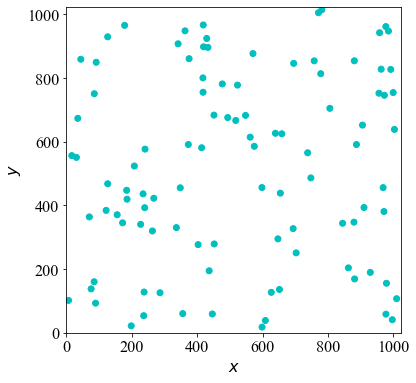

In [60]:
# loop BH over different theta
keys = ['create_tree', 'bh_calc', 'direct_sum']
times = {key:[] for key in keys}
depths = []
max_errs = []
all_data = []
theta_range = np.arange(0, 15, 0.5)
for theta in theta_range:
    very_start = time.time()
    print("Timer elapsed reset.")
    n = 100
    # theta = 0.5
    print(f"n = {n}, theta = {theta}")

    np.random.seed(4)
    grid = Grid(size=1024)
    all_coords = [i for i in range(n)]
    all_q = np.random.random(len(all_coords))*10+50
    all_particles = grid.create_particles(len(all_coords), all_coords=None, all_q=all_q)
    # print('Grid and particles initialised.')
    # print('Time elapsed:', time.time() - very_start)

    tic = time.perf_counter()
    bh_create_tree(grid, grid.particles)
    toc = time.perf_counter()
    times[keys[0]].append(toc-tic)
    # print('Time elapsed:', time.time() - very_start)

    depth = find_bh_tree_depth(grid.rootbox, grid.size)
    depths.append(depth)
    # print("BH tree depth:", depth)
    # print('Time elapsed:', time.time() - very_start)

    tic = time.perf_counter()
    bh_calc_phi(grid, theta)
    toc = time.perf_counter()
    times[keys[1]].append(toc-tic)
    print('BH calculated.')
    # print('Time elapsed:', time.time() - very_start)

    bh = np.array(grid.get_all_phi())
    # print('Time elapsed:', time.time() - very_start)

    tic = time.perf_counter()
    grid_direct_sum(grid)
    toc = time.perf_counter()
    times[keys[2]].append(toc-tic)
    print('Direct calculated.')
    # print('Time elapsed:', time.time() - very_start)

    exact = np.array(grid.get_all_phi())
    bh_errs = (bh-exact)/exact

    data = abs(bh_errs)
    all_data.append(data)
    max_errs.append(max(data))

grid.draw()

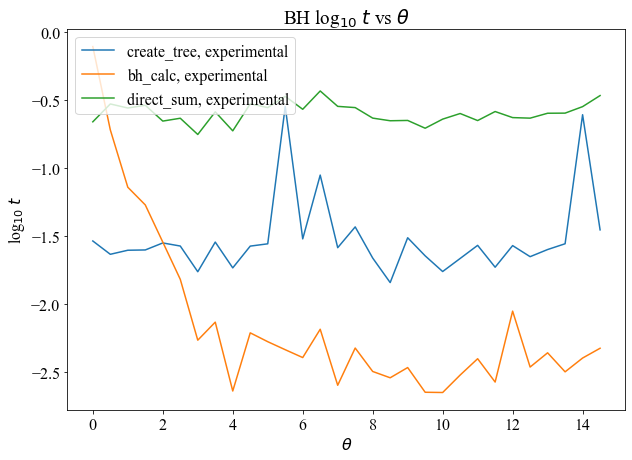

In [61]:
# t vs theta
xlabel = 'theta_range'
x = eval(xlabel)
fig, ax = plt.subplots(figsize = (10,7))
excluded_keys = ()
step_keys = [key for key in keys if key not in excluded_keys]
for i in range(len(step_keys)):
    y = np.array(times[step_keys[i]])
    a, b = np.polyfit(X, Y, 1)
    ax.plot(x, np.log10(y), label = f'{keys[i]}, experimental')
    # ax.plot(X, Y, label = f'{keys[i]}, experimental')
    # ax.plot(X, a*X+b, label=f'{keys[i]}, fit  $t \propto N^{{{a:.2f}}}$', linestyle='--')

plt.legend(loc='upper left')
ax.set_xlabel('$\\theta$')
ax.set_ylabel('log$_{10}$ $t$')
title = f'BH log$_{{{10}}}$ $t$ vs $\\theta$'
ax.set_title(title)
plt.show()
# plt.savefig(title + '.jpg', dpi=300)

As observed above, as $\theta$ approaches 0, the time taken for the BH code to run becomes comparable to that of direct summation. Whereas for large $\theta$, the BH code runs order of magnitude times faster but as we will see below, this sacrifies the accuracy of the calculation.

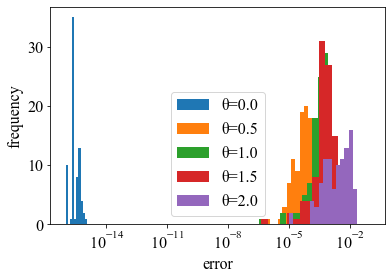

In [70]:
# error distribution with varying theta
for data, theta in zip(all_data[:5], theta_range[:5]):
    # if zeros exist:
    if any(data==0):
        tot = len(data)
        data = data[data!=0]
        tot_no0 = len(data)

    # create logspace bins
    minexpnt = np.floor(np.log10(min(data)))
    maxexpnt = np.ceil(np.log10(max(data)))
    bins = np.logspace(minexpnt, maxexpnt, 20)

    # create histogram with logscale bins
    plt.hist(data, bins=bins, log=True, label=f'θ={theta}')
    plt.xlabel('error')
    plt.ylabel('frequency')
    plt.xscale('log')
    plt.yscale('linear')
    plt.legend()
    # plt.show()

Graph above shows the machine level precision achieved when $\theta$=0. This is essentially direct calculation. As $\theta$ increases, the errors increases as more approximations are made at coarser levels.
At some point, any further increase in $\theta$ would not change anything (error saturates) as the particles are only interacting with the c.o.m. of the entire system (i.e. the coarsest level), as shown in the figure below.

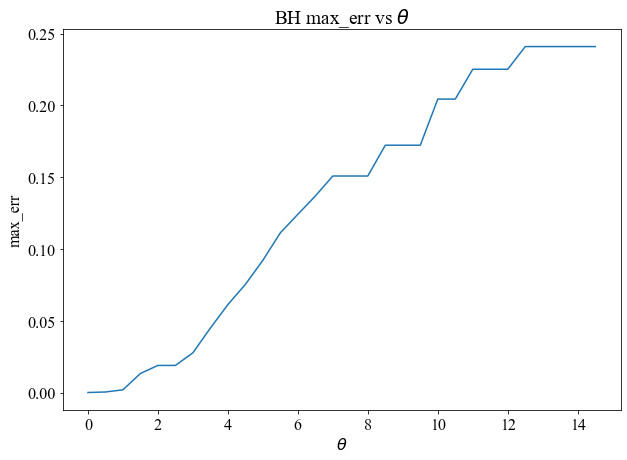

In [72]:
# max_err vs N
xlabel = 'theta_range'
x = eval(xlabel)
fig, ax = plt.subplots(figsize = (10,7))
excluded_keys = ()
y = np.array(max_errs)
# X = np.log10(x[x!=0])
# Y = np.log10(y[x!=0])
# a, b = np.polyfit(X, Y, 1)
ax.plot(x, y)

ax.set_xlabel('$\\theta$')
ax.set_ylabel('max_err')
title = f'BH max_err vs $\\theta$'
ax.set_title(title)
plt.show()
# plt.savefig(title + '.jpg', dpi=300)

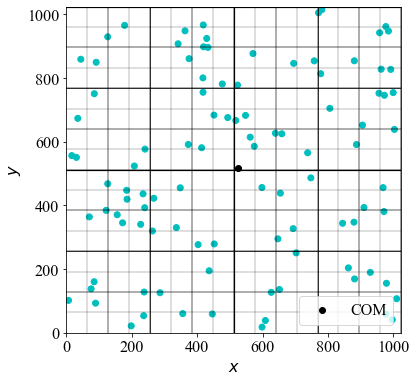

In [73]:
grid.draw()
grid.ax.scatter(*grid.rootbox.com_R, color='k', label='COM')
grid.ax.legend(loc='lower right')
grid.draw_squares(4)
grid.fig

The figure below displays the error of the particles on a spatial grid. This is evaluated at the largest $\theta$. As the potential are evaluated between the particles and the c.o.m. of the system, particles closer to the centre have a higher error as they are closer to the c.o.m. of the system.

14.5


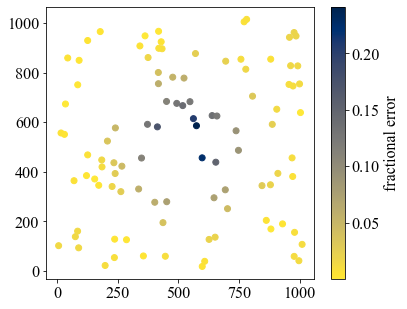

In [77]:
# cm = plt.cm.get_cmap(''viridis'')
print(theta_range[-1])
fig, ax = plt.subplots(figsize=(6,5))
x, y = zip(*grid.get_all_coords())
data = abs(bh_errs)
# data = abs(fmm_errs)
sc = plt.scatter(x, y, c=data, vmin = min(data), vmax=max(data), cmap = 'cividis_r')
plt.colorbar(sc, label='fractional error (abs.)')
plt.show()

# 4 The Fast Multipole Method
## 4.1 General Idea
The general idea behind FMM is to effectively form representations of source groups and target groups. Representations of source groups are formed by multipole expansions, whereas that of target groups are formed by what is known as local expansions. The point of these representations is to reduce the number of operations between well-separated source and target groups as shown in the figure below. It may not seem obvious from this figure that the introduction of target representation in addition to source representation would further reduce the complexity of the problem. The power of the target representation can only be seen when there are multiple groups of source representations.

Similar to the BH method, these representations also occur in hierarchical groups. The main difference is that the BH method only form source (but not target) representations, and that the FMM representations are re-used across different hierarchy levels, unlike the Barnes-Hut method which evaluates the representations at every level.

The multipole expansion of FMM can be seen as an extension of the BH method. The error introduced by FMM can in principle be reduced to machine precision by an increasing number of expansion terms, which makes it an ideal tool to tackle any level of error tolerance.


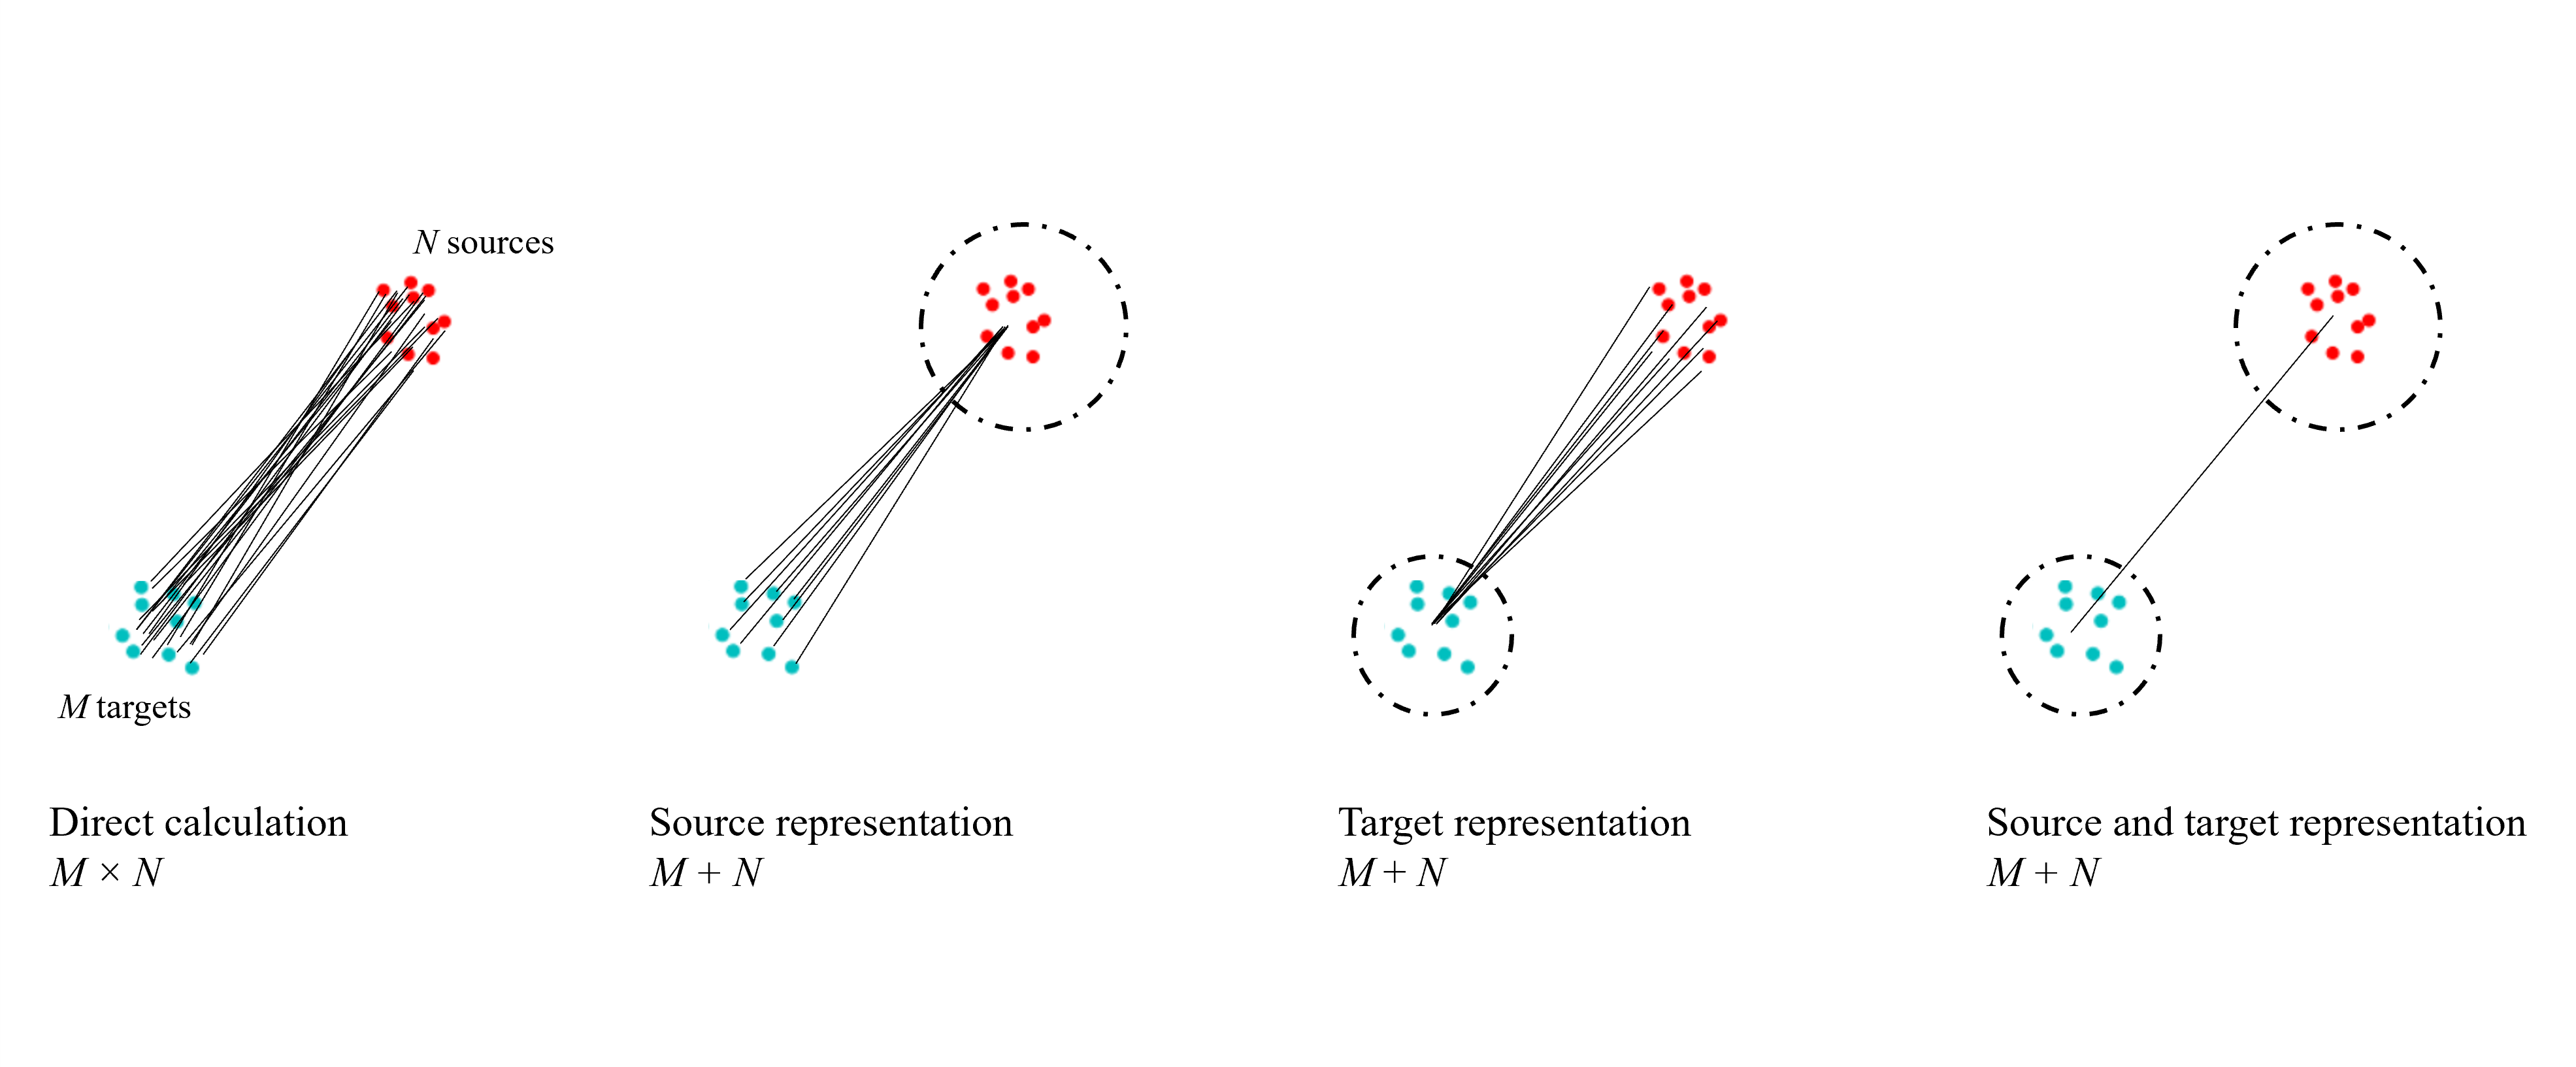
Figure 5: Source and target representations.

## 4.2 Algorithm
### 4.2.1 Tree construction
The FMM tree construction is similar to that of the BH method, but there is no need to introduce the particle level by level here as the boxes where the particles belong are only required at the finest level for the S2M evaluation (explained in the next section). Unlike the BH method, for simplicity, the code used in this work creates equal number of 4 children for each boxes at every level $l$, up to the maximum level $L$. Hence, there are $4^{l}$ boxes at each level regardless of the spatial distribution of the particles. Also, the maximum allowed number of particles in each of the $4^{L}$ leaf boxes is fixed to a constant number $ptcmax$ where $ptcmax \sim O(1) << N$.

For example, for $N = 1000$,  $ptcmax$ can be 4, so that at the leaf box level, there will be no more than 4 particles. Assuming a uniform particle distribution, the number of leaf boxes required is around $1000/4=250$ leaf boxes. This hence require 4 levels of refinement (as $\log_4{250} \approx 4$). 

Each of the boxes in tree will contain information about the identity of the parent box and children boxes, and will be used to store two arrays of length $p+1$, corresponding to the source and target representation terms expanded to the order of the expansion $p$.

### 4.2.2. Potential calculation
The following sections details the 6 major steps of the FMM potential calculation, using the tree structure as described in the previous section. The expressions of the expansions and steps are all based on [6].
#### 4.2.2.1 S2M: Source representations.
The S2M (source to multipole) calculates the multipole expansion (sources representation) coefficients for each leaf box at the finest level $L$. Consider a box containing $m$ charges of strengths $q_i, \{i = 1, ..., m\}$, located at points $z_i, \{i = 1, ..., m\}$ with $|z_i| < r$ relative to the centre of the box (source centre). The expansion coefficients are given by 
\begin{equation}
    Q = \sum_{i=1}^m q_i
\end{equation}
and 
\begin{equation}
    a_k = \sum_{i=1}^m \frac{-q_iz_i^k}{k}.
\end{equation}
Where $k = 1, ..., p$ is a label for the $k^{\text{th}}$ order expansion term of the multipole. These multipole coefficients can be used to approximate the potential for any given target located at point $z$ relative to the source centre, with $|z|>r$ as
\begin{equation}
    u(z) = Q\log{z} + \sum_{k=1}^p \frac{a_k}{z_k}.
\end{equation}
As $p$ approaches infinity, this expression coefficients form a source representation that equals the exact form of the potential. Convergence requirements are discussed in more detail in \cite{beatson1997short}.
Note that this step is essentially a generalisation of the BH method. The c.o.m. approximation is simply the 0th-order term of this expansion. Analogous to the BH method, this step reduces a $O(MN)$ operation between $M$ sources well separated from $N$ targets to $O(M+N)$, as $M$ operations are required to calculate the source coefficients, which can be reused for the $N$ targets.

Note that we will omit the negative sign (of the potential) here for notation clarity, it could simply be introduced again at the end of the calculations.



#### 4.2.2.2 M2M: Transferring source representations.
Instead of recalculating the source representation for every box at the higher level which would result in an overall $N\log N$ complexity, a translation of these coefficients at the leaf level can be used to pass these coefficients to their parents, all the way up to the coarsest level $l = 0$. A box at level $l$ simply sums up the (origin-translated) multipole expansion coefficients of its 4 children at level $l+1$, and then (alongside with its "siblings" at level $l$) passes this information to its parent at level $l-1$. The translated coefficients $b_l$ can be calculated using 
\begin{equation}
    b_l = -\frac{a_oz_o^l}{l} + \sum_{k=1}^l a_kz_o^{l-k}\binom{l-1}{k-1}.
\end{equation}
where $z_0$ is the position of the child box relative to that of its parent box.



#### 4.2.2.3 M2L: Evaluating target representations from (far) source representations.
This is a core part of the FMM algorithm, whic is also a bottleneck of the fmm algorithm efficiency. For each box at a given level $l$, the interaction list the box is defined as the list of boxes that are well-separated from itself (at level $l$) and not well-separated from its parent box (see below Figure).
The local expansion terms do not exactly represent the target particles -- instead, it represents the potential evaluated nearby a target centre, including the effects of the multiple source groups that are well separated from the target centre. This representation is useful as the target particles around the target centre can reuse the same coefficients to evaluate the potential at their respective (target) locations (in the L2P step), which is a key distinction compared to the BH method.
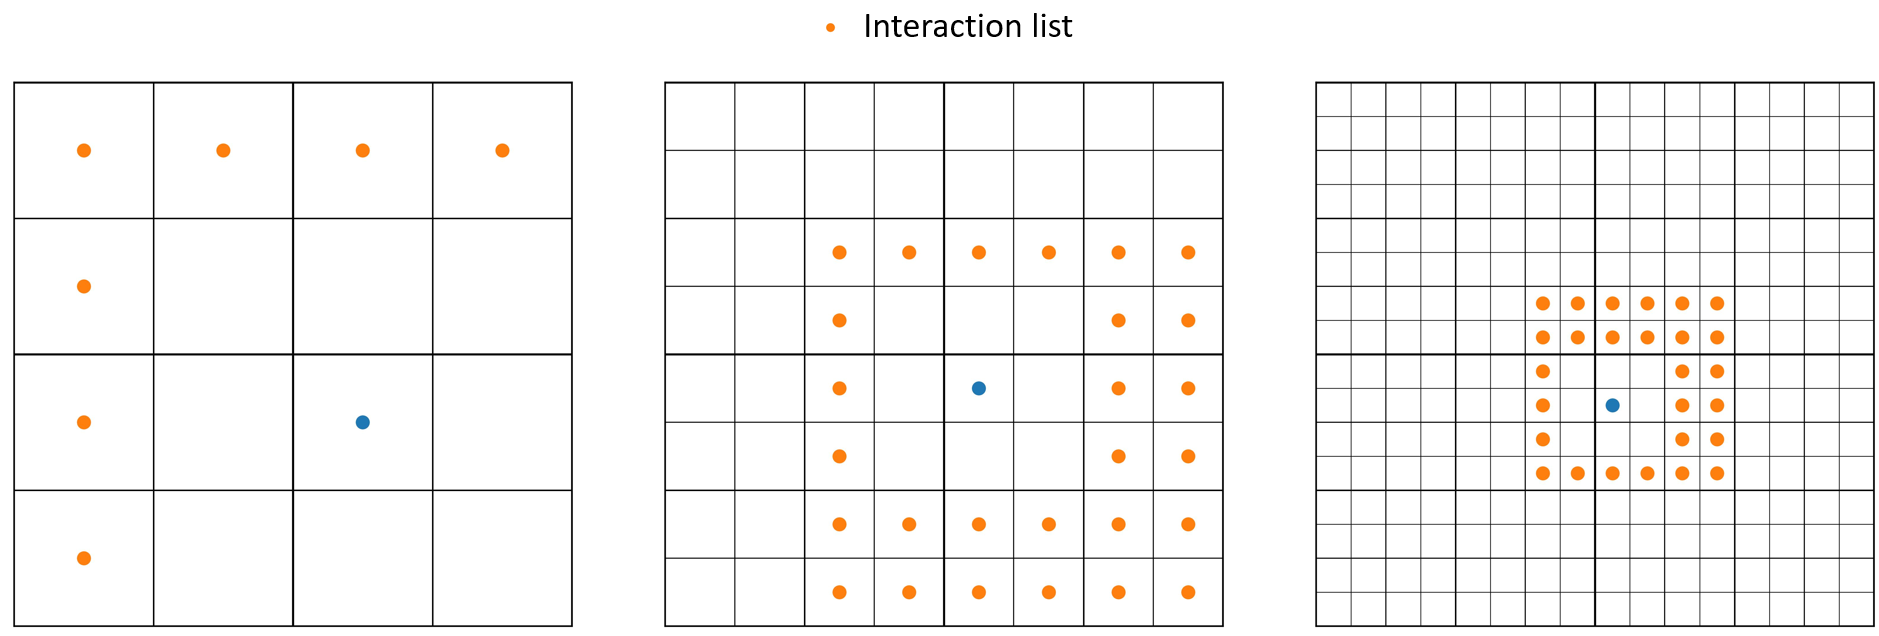

Figure 6: Source and target representations.

#### 4.2.2.4 L2L: Transferring target representations.
Actually lso includes info about where the sources are

#### 4.2.2.5 L2P: Using target representations to evaluate the potential.

#### 4.2.2..6 P2P: Evaluating potential directly from nearby sources.


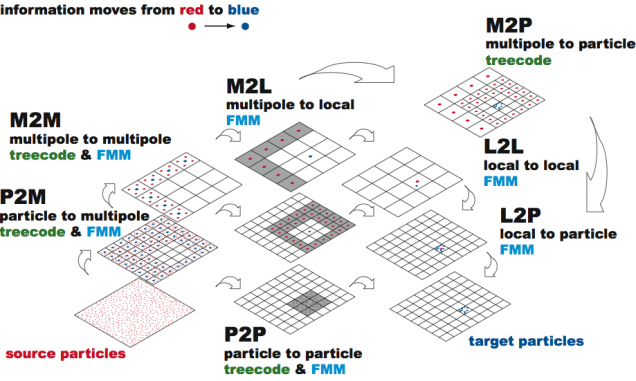

Visualisation of the FMM procedures. Above figure taken from [7].

## 4.3 Implementation: Time Complexity and Error Analysis
### 4.3.1 Time Complexity - varying N
The key concepts to understand the origin of the $O(N)$ complexity of the FMM are that 

a) $ptcmax \times 4^L = N$, 

b) the total number of boxes is $\sum_{l=0}^{L} 4^{l} \sim 4^L = \frac{N}{ptcmax}$, 

c) the two translations and the M2L steps require $O(p^2)$ operations for every box in the tree. An expression of the total operation count is given by
\begin{equation}
    Np + (1+27+1)\left(\frac{N}{ptcmax}\right)p^2 + Np + (9)N\times ptcmax
\end{equation}
as shown in [6]. Note that the above expression is valid for a uniform particle distribution. The terms correspond to the S2M, M2M, M2L, L2L, L2P, and P2P operations.

Text(0.5, 1.0, 'Number of levels vs $N$')

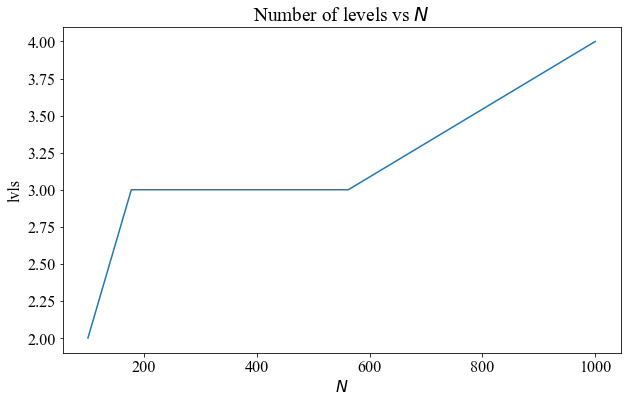

In [80]:
xlabel = 'N_range'
x = eval(xlabel)
y = lvlss
# y = max_errs

fig, ax = plt.subplots(figsize = (10,6))
# ax.plot(np.log10(x), np.log10(y))
ax.plot(x, y)
ax.set_xlabel(f'${xlabel[0]}$')
ax.set_ylabel('lvls')
ax.set_title('Number of levels vs $N$')
# ax.set_ylabel('max_error')
# print(p_range)

Individual components of the FMM algorithm. As shown in the figure, the FMM calculation is dominated by the M2L step (note that all the other component times are multiplied by 10 for easier visual view). The fmm_calc is the sum of 'S2M', 'M2M', 'M2L', 'L2L', 'L2P', 'P2P'; whereas construct_tree is timed separately.

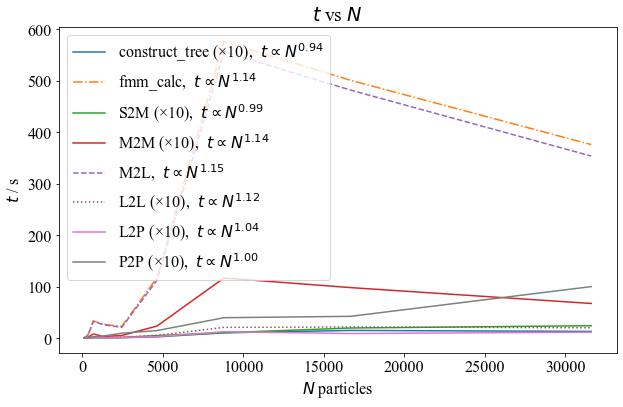

In [ ]:
# t vs N
xlabel = 'N_range'
x = eval(xlabel)
fig, ax = plt.subplots(figsize = (10,6))
excluded_keys = ('direct_sum')
step_keys = [key for key in keys if key not in excluded_keys]
# step_keys = keys[1:]
for i in range(len(step_keys)):
    y = np.array(times[step_keys[i]])
    X = np.log(x[x!=0])
    Y = np.log(y[x!=0])
    a, b = np.polyfit(X, Y, 1)
    # ax.plot(X, Y, label = f'{keys[i]},  $t \propto N^{{{a:.2f}}}$')
    # ax.plot(x, np.exp(b)*x**a, label = f'{step_keys[i]},  $t \propto {xlabel[0]}^{{{a:.2f}}}$')
    linestyle = '-'
    label = step_keys[i] + ' (×10)'
    # label = step_keys[i]
    y = y * 10
    if step_keys[i] == 'M2L':
        linestyle = '--'
    elif step_keys[i] == 'L2L':
        linestyle = ':'
    elif step_keys[i] == 'fmm_calc':
        linestyle = '-.'
    # except these, show all others x10 (as the others are likely to have smaller values)
    if step_keys[i] in ('fmm_calc', 'M2L', 'direct_sum'):
        label = step_keys[i]
        y = y / 10

    ax.plot(x, y, label=f'{label},  $t \propto {xlabel[0]}^{{{a:.2f}}}$', linestyle=linestyle)

    # ax.plot(X, a*X+b)

plt.legend(loc='upper left')
ax.set_xlabel(f'log ${xlabel[0]}$')
ax.set_xlabel('$N$ particles')
# ax.set_xlabel('log θ')
ax.set_ylabel('log $t$')
ax.set_ylabel('$t$ / s')
ax.set_title(f'$t$ vs ${xlabel[0]}$')
plt.show()

Below figure shows the timing variation of the entire fmm_calc function and the consturc_tree function as a function of $N$. Steps are observed as the number of refinement levels increases steo-by-step as the number of particles are increased.

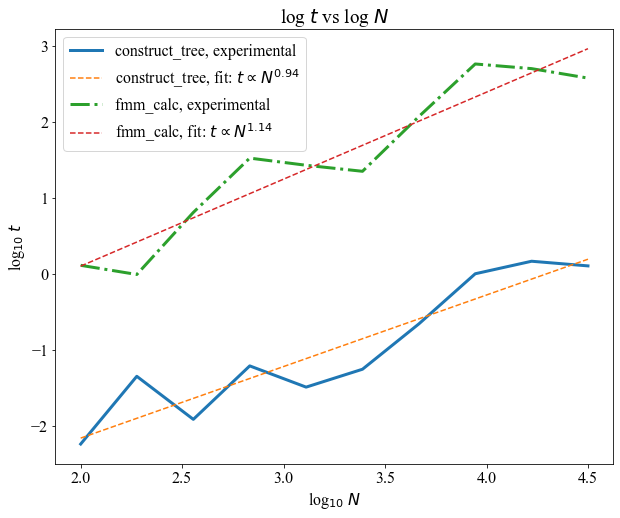

In [ ]:
# logt vs logN main components
xlabel = 'N_range'
x = eval(xlabel)
fig, ax = plt.subplots(figsize = (10,8))
# ['construct_tree', 'fmm_calc', 'direct_sum', 'S2M', 'M2M', 'M2L', 'L2L', 'L2P', 'P2P']
excluded_keys = ('S2M', 'M2M', 'M2L', 'L2L', 'L2P', 'P2P', 'direct_sum')
# excluded_keys = ('direct_sum', 'construct_tree')
step_keys = [key for key in keys if key not in excluded_keys]

for i in range(len(step_keys)):
    y = np.array(times[step_keys[i]])
    X = np.log10(x[x!=0])
    Y = np.log10(y[x!=0])
    a, b = np.polyfit(X, Y, 1)
    linestyle = '-'
    # label = step_keys[i] + ' (×10)'
    label = step_keys[i]
    if step_keys[i] == 'M2L':
        linestyle = '--'
    elif step_keys[i] == 'L2L':
        linestyle = ':'
    elif step_keys[i] == 'fmm_calc':
        linestyle = '-.'
    # except these, show all others x10 (as the others are likely to have smaller values)
    # if step_keys[i] in ('fmm_calc', 'M2L', 'direct_sum'):
    #     label = step_keys[i]

    ax.plot(X, Y, label=f'{label}, experimental', linestyle=linestyle, lw=3)
    ax.plot(X, a*X+b, label=f'{label}, fit: $t \propto {xlabel[0]}^{{{a:.2f}}}$', linestyle='--')
    # ax.plot(x, np.exp(b)*x**a, label = f'{step_keys[i]},  $t \propto {xlabel[0]}^{{{a:.2f}}}$')
    # ax.plot(x, y, label=f'{label},  $t \propto {xlabel[0]}^{{{a:.2f}}}$', linestyle=linestyle)

    # ax.plot(X, a*X+b)

plt.legend(loc='upper left')
ax.set_xlabel(f'log$_{{{10}}}$ ${xlabel[0]}$')
# ax.set_xlabel('$N$ particles')
# ax.set_xlabel('log θ')
ax.set_ylabel('log$_{10}$ $t$')
# ax.set_ylabel('$t$ / s')
ax.set_title(f'log $t$ vs log ${xlabel[0]}$')
plt.show()

The spatial distribution of the errors are shown in the below figure. The highest errors appear at the edges as those are the places furthest from the centres of the boxes.

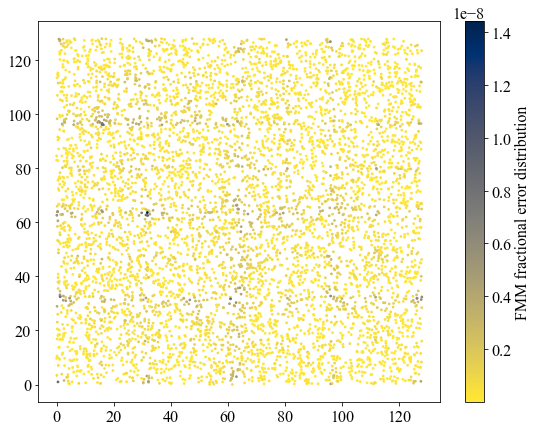

In [ ]:
# cm = plt.cm.get_cmap(''viridis'')
fig, ax = plt.subplots(figsize=(9,7))
x, y = (lambda x: (x.real, x.imag))(gridcomplex.get_all_coords())

data = abs(fmm_errs)
sc = plt.scatter(x, y, c=data, vmin = min(data), vmax=max(data), cmap = 'cividis_r', s=3)
plt.colorbar(sc, label='FMM fractional error distribution')
plt.show()

### Time complexity - varying Order of expansion

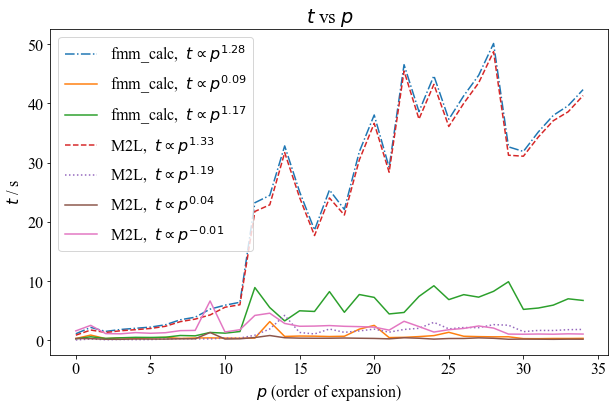

N=500


In [ ]:
# t vs p
xlabel = 'p_range'
x = eval(xlabel)
fig, ax = plt.subplots(figsize = (10,6))
step_keys = [keys[1]]+keys[3:]
for i in range(len(step_keys)):
    # y = depths
    # y = max_err
    y = np.array(times[step_keys[i]])
    X = np.log(x[x!=0])
    Y = np.log(y[x!=0])
    a, b = np.polyfit(X, Y, 1)
    # ax.plot(X, Y, label = f'{keys[i]},  $t \propto N^{{{a:.2f}}}$')
    # ax.plot(x, np.exp(b)*x**a, label = f'{step_keys[i]},  $t \propto {xlabel[0]}^{{{a:.2f}}}$')
    linestyle = '-'
    # label = step_keys[i] + ' (×10)'
    y = y * 10
    if step_keys[i] == 'M2L':
        linestyle = ':'
    elif step_keys[i] == 'L2L':
        linestyle = '--'
    elif step_keys[i] == 'fmm_calc':
        linestyle = '-.'
    if step_keys[i] in ('fmm_calc', 'M2L'):
        label = step_keys[i]
        y = y/10

    ax.plot(x, y, label = f'{label},  $t \propto {xlabel[0]}^{{{a:.2f}}}$', linestyle=linestyle)

    # ax.plot(X, a*X+b)

    plt.legend()

ax.set_xlabel('log $N$')
ax.set_xlabel('$p$ (order of expansion)')
# ax.set_xlabel('log θ')
ax.set_ylabel('log $t$')
ax.set_ylabel('$t$ / s')
ax.set_title('$t$ vs $p$')
plt.show()
print(f"N={n}")

Machine level precision is achieved around $p$=28.

-9.701159894611196


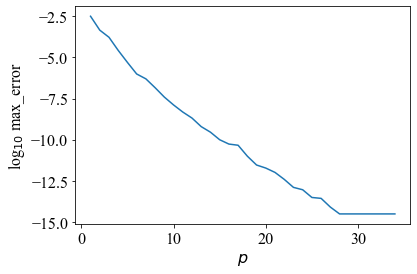

N=500


In [ ]:
# error vs p range
x = p_range
fig, ax = plt.subplots()
# y = np.array(times[keys[i]])
y = np.array(max_errs)
X = np.log10(x[x!=0])
Y = np.log10(y[x!=0])
a, b = np.polyfit(X, Y, 1)
# ax.plot(X, Y, label = f'{keys[i]},  $t \propto N^{{{a:.2f}}}$')
ax.plot(x[x>0], Y) #, label = f'{keys[i]},  $t \propto N^{{{a:.2f}}}$')
# ax.plot(x, y, label = f'max_error,  $t \propto p^{{{a:.2f}}}$')
# ax.plot(X, a*X+b)

# plt.legend()

print(a)
# ax.set_xlabel('log $N$')
ax.set_xlabel('$p$')
# ax.set_ylabel('log $t$')
ax.set_ylabel('log$_{10}$ max_error')
# ax.set_ylabel('$t$')
plt.show()
print(f"N={n}")

In [ ]:
# FMM
# p_range = np.arange(0,35).astype('i')
p_range = []
ptcmax_range = []
N_range = np.logspace(2,3,5).astype('i')
# N_range = np.logspace(2,4,8).astype('i') # 100-
# N_range = np.logspace(2,4.5,10).astype('i') # (100-31622)
# N_range = [500]
max_errs = []
lvlss = []
innerkeys = ['S2M', 'M2M', 'M2L', 'L2L', 'L2P', 'P2P']
keys = ['construct_tree', 'fmm_calc', 'direct_sum'] + innerkeys
times = {key:[] for key in keys}

# for p in p_range:

for n in N_range:
    # n = 500
    # n_range.append(n)
    p = 10
    p_range.append(p)
    ptcmax = 10
    ptcmax_range.append(ptcmax)
    lvls = int(np.ceil(np.emath.logn(4, n/ptcmax))) #+1
    lvlss.append(lvls)
    print()
    very_start = time.time()
    print("Timer elapsed reset.")
    print(f"------ p = {p}, n = {n}, lvls = {lvls}, ptcmax = {ptcmax} ------")
    np.random.seed(4)
    gridcomplex = GridComplex(size=128)
    all_coords = [i for i in range(n)]
    all_q = np.random.random(len(all_coords))*10+50
    all_particles = gridcomplex.create_particles(len(all_coords), all_coords=None, all_q=all_q)
    print('Grid and particles initialised.')
    # print('Time elapsed:', time.time() - very_start)

    # nextra = 10
    # xs = np.random.random(nextra) + 10
    # ys = np.random.random(nextra) + 10
    # extra_coords = xs + 1j*ys
    # extra_q = np.random.random(nextra)*20 - 10
    # for coords, q in zip(extra_coords, extra_q):
    #     Particle(gridcomplex, coords, q)
    tic = time.perf_counter()
    tree, idx_helpers, crowded = construct_tree_fmm(lvls, gridcomplex, ptcmax, p)
    toc = time.perf_counter()
    if crowded:
        while crowded:
            lvls+=1
            tic = time.perf_counter()
            tree, idx_helpers, crowded = construct_tree_fmm(lvls, gridcomplex, ptcmax, p)
            toc = time.perf_counter()
        print(f'lvls readjusted to {lvls}.')
    times[keys[0]].append(toc-tic)
    print(f'{keys[0]} ed.')
    # print('Time elapsed:', time.time() - very_start)

    tic = time.perf_counter()
    innertimes = fmm_calc_phi(tree, idx_helpers, lvls, p)
    toc = time.perf_counter()
    times[keys[1]].append(toc-tic)
    for key in innerkeys:
        if innertimes[key]:
            times[key].append(innertimes[key][0])
    print(f'{keys[1]} ed.')
    # print('Time elapsed:', time.time() - very_start)

    fmm = gridcomplex.get_all_phi()
    # print('Time elapsed:', time.time() - very_start)

    # tic = time.perf_counter()
    # grid_direct_sum_complex(gridcomplex)
    # toc = time.perf_counter()
    # times[keys[2]].append(toc-tic)
    # print(f'{keys[2]} ed.')
    # print('Time elapsed:', time.time() - very_start)

    # exactcomplex = np.array(gridcomplex.get_all_phi())
    # # np.around((fmm-np.array(exact))/exact, 6)
    # fmm_errs = (fmm-exactcomplex).real/exactcomplex.real
    # # fmm_errs_real = (fmm-exact).real/exact

    # data = abs(fmm_errs)
    # max_errs.append(max(data))

    # # if zeros exist:
    # if any(data==0):
    #     tot = len(data)
    #     data = data[data!=0]
    #     tot_no0 = len(data)
    #     print(f'Dropped {tot-tot_no0} values that are 0.')

    # # create logspace bins
    # minexpnt = np.floor(np.log10(min(data)))
    # maxexpnt = np.ceil(np.log10(max(data)))
    # bins = np.logspace(minexpnt, maxexpnt, 20)

    # # create histogram with logscale bins
    # plt.hist(data, bins=bins, log=True)
    # plt.xscale('log')
    # plt.yscale('linear')


Timer elapsed reset.
------ p = 10, n = 100, lvls = 2, ptcmax = 10 ------
Grid and particles initialised.
Leaf box(es) centered at [(16+48j)] too crowded, it has [10] particles. Try increasing 'lvls'.
lvls readjusted to 3.
construct_tree ed.

start of fmm calc
Time elapsed: 1.3616447448730469
end of fmm calc
fmm_calc ed.

Timer elapsed reset.
------ p = 10, n = 177, lvls = 3, ptcmax = 10 ------
Grid and particles initialised.
construct_tree ed.

start of fmm calc
Time elapsed: 1.4645304679870605
end of fmm calc
fmm_calc ed.

Timer elapsed reset.
------ p = 10, n = 316, lvls = 3, ptcmax = 10 ------
Grid and particles initialised.
Leaf box(es) centered at [(56+8j), (120+40j), (40+88j)] too crowded, it has [10, 11, 14] particles. Try increasing 'lvls'.
lvls readjusted to 4.
construct_tree ed.

start of fmm calc
Time elapsed: 7.361466884613037
end of fmm calc
fmm_calc ed.

Timer elapsed reset.
------ p = 10, n = 562, lvls = 3, ptcmax = 10 ------
Grid and particles initialised.
Leaf box(es

In [81]:
# t cmpnt vs N
# t vs N
xlabel = 'N_range'
x = eval(xlabel)
fig, ax = plt.subplots(figsize = (8,6))
cmpnt = 'construct_tree'
y = np.array(times[cmpnt])
X = np.log(x[x!=0])
Y = np.log(y[x!=0])
a, b = np.polyfit(X, Y, 1)
# ax.plot(X, Y, label = f'{keys[i]},  $t \propto N^{{{a:.2f}}}$')
ax.plot(x, y, label = f'expm  $t_{{{cmpnt}}}$')
ax.plot(x, np.exp(b)*x**a, label = f'Power-law fit  $t \propto {xlabel[0]}^{{{a:.2f}}}$', linestyle = '--')
X = x[x!=0]
Y = np.log(y[x!=0])
a, b = np.polyfit(X, Y, 1)
ax.plot(x, np.exp(b)*np.exp(a*x), label = f'Exponential fit  $t \propto e^{{{{{a:.2f}}}{xlabel[0]}}}$', linestyle = ':')

# ax.plot(x, y, label = f'expm  $t \propto {xlabel[0]}^{{{a:.2f}}}$', linestyle=linestyle)

    # ax.plot(X, a*X+b)

plt.legend()

ax.set_xlabel('$N$')
ax.set_ylabel(f'$t_{{{cmpnt}}}$ / s')
ax.set_title(f'$t_{{{cmpnt}}}$ vs $p$')
plt.show()

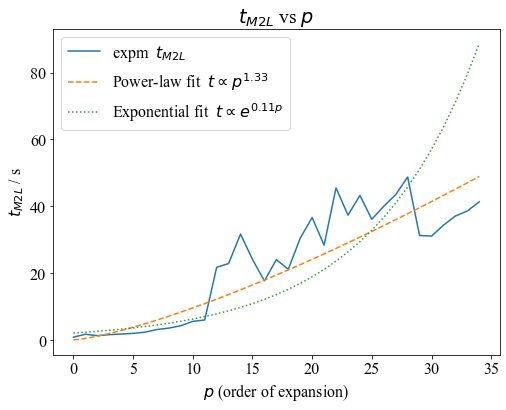

N=500


In [ ]:
# t M2L vs p
# t vs p
xlabel = 'p_range'
x = eval(xlabel)
fig, ax = plt.subplots(figsize = (8,6))
y = np.array(times['M2L'])
X = np.log(x[x!=0])
Y = np.log(y[x!=0])
a, b = np.polyfit(X, Y, 1)
# ax.plot(X, Y, label = f'{keys[i]},  $t \propto N^{{{a:.2f}}}$')
ax.plot(x, y, label = 'expm  $t_{M2L}$')
ax.plot(x, np.exp(b)*x**a, label = f'Power-law fit  $t \propto {xlabel[0]}^{{{a:.2f}}}$', linestyle = '--')
X = x[x!=0]
Y = np.log(y[x!=0])
a, b = np.polyfit(X, Y, 1)
ax.plot(x, np.exp(b)*np.exp(a*x), label = f'Exponential fit  $t \propto e^{{{{{a:.2f}}}{xlabel[0]}}}$', linestyle = ':')

# ax.plot(x, y, label = f'expm  $t \propto {xlabel[0]}^{{{a:.2f}}}$', linestyle=linestyle)

    # ax.plot(X, a*X+b)

plt.legend()

ax.set_xlabel('$p$ (order of expansion)')
ax.set_ylabel('$t_{M2L}$ / s')
ax.set_title('$t_{M2L}$ vs $p$')
plt.show()
print(f"N={n}")

In [82]:
xstr = 'N_range'
x = np.arange(len(eval(xstr)))
# x = np.arange(len(p_range[:5]))  # the label locations
# x = np.arange(len(p_range[:5]))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

# fig, ax = plt.subplots(layout='constrained')
fig, ax = plt.subplots(figsize=(15,10))

for step, t in times.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, t, width, label=step)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('$t$ / s')
# ax.set_ylabel('log $t$ / s')
ax.set_title(f"$t$ vs ${xstr[0]}$")
ax.set_xticks(x + width, p_range[:5])
ax.legend(loc='upper left')
# ax.set_ylim(0, 250)

plt.show()

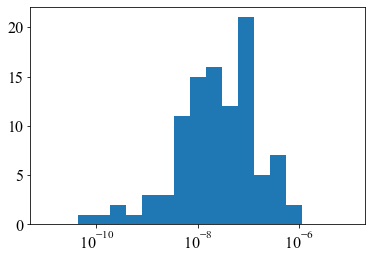

In [ ]:
data = abs(fmm_errs)

# if zeros exist:
if any(data==0):
    tot = len(data)
    data = data[data!=0]
    tot_no0 = len(data)
    print(f'Dropped {tot-tot_no0} values that are 0.')

# create logspace bins
minexpnt = np.floor(np.log10(min(data)))
maxexpnt = np.ceil(np.log10(max(data)))
bins = np.logspace(minexpnt, maxexpnt, 20)

# create histogram with logscale bins
plt.hist(data, bins=bins, log=True)
plt.xscale('log')
plt.yscale('linear')

In [ ]:
grid_direct_sum_complex(grid)
exact = np.array(grid.get_all_phi())
# np.around((fmm-np.array(exact))/exact, 6)
(fmm-exact).real/exact.real

array([ 3.07868206e-12, -3.12546613e-14, -1.30681449e-13,  1.24951891e-13,
       -2.72171545e-12,  2.62502830e-14,  1.06056589e-12,  1.08590419e-12,
       -2.06145038e-13,  1.02975236e-14,  2.83688773e-12,  5.93157258e-14,
        5.83636162e-14,  2.31472753e-13,  4.39595033e-13])

## References
[1] J. Barnes and P. Hut, “A hierarchical O(N log N) force-calculation algorithm,” , vol. 324, pp. 446–449, Dec. 1986.

[2] L. Greengard and V. Rokhlin, “A fast algorithm for particle simulations,” Journal of Computational Physics, vol. 73, no. 2, pp. 325–348, 1987.

[3] R. W. Hockney and J. W. Eastwood, Computer Simulation Using Particles. McGraw-Hill, New York, 1981.

[4] J. S. Bagla, “Cosmological n-body simulation: Techniques, scope and status,” Current Science, vol. 88, pp. 1088–1100, 2023/04/30/ 2005. Full publication date: 10 April 2005.

[5] T. Ventimiglia and K. Wayne, “The barnes-hut algorithm,” 2011.

[6] R. Beatson and L. Greengard, “A short course on fast multipole methods,” 1997

[7] Yokota R, Barba LA. A tuned and scalable fast multipole method as a preeminent algorithm for exascale systems. The International Journal of High Performance Computing Applications. 2012;26(4):337-346. doi:10.1177/1094342011429952